In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds

from IPython.core.interactiveshell import InteractiveShell


In [2]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 设置嵌入层 第一个参数是词汇量  第二个参数是词的维度
embedding_layer = keras.layers.Embedding(1000, 32)

vocab_size = 10000
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)


In [4]:
len(train_data)

25000

In [5]:
# 输出的是被编码后的词  每一个数字代表一个特定的单词
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
# 得到每个单词的索引 就可以将上面的数字映射为单词
word_index = imdb.get_word_index()
# 字典表达式 将每个单词对应的索引全部加3 因为后面要添加三个 先留出位置
word_index = {k: v+3 for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

print('反转前---' * 10)
list(word_index.items())[:10]

print('\n')
print('反转后---' * 10)

# word_index反转
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

list(reverse_word_index.items())[:10]

def decode_review(text):
    # 如果没有根据i找到对应的单词 就返回?
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])


反转前---反转前---反转前---反转前---反转前---反转前---反转前---反转前---反转前---反转前---


[('fawn', 34704),
 ('tsukino', 52009),
 ('nunnery', 52010),
 ('sonja', 16819),
 ('vani', 63954),
 ('woods', 1411),
 ('spiders', 16118),
 ('hanging', 2348),
 ('woody', 2292),
 ('trawling', 52011)]



反转后---反转后---反转后---反转后---反转后---反转后---反转后---反转后---反转后---反转后---


[(34704, 'fawn'),
 (52009, 'tsukino'),
 (52010, 'nunnery'),
 (16819, 'sonja'),
 (63954, 'vani'),
 (1411, 'woods'),
 (16118, 'spiders'),
 (2348, 'hanging'),
 (2292, 'woody'),
 (52011, 'trawling')]

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [7]:
maxlen = 500
train_data = keras.preprocessing.sequence.pad_sequences(sequences=train_data, 
                                                        maxlen=maxlen, 
                                                        value=word_index["<PAD>"], # 浮点数，此值将在填充时代替默认的填充值0
                                                        padding='post', # ‘pre’或‘post’，确定当需要补0时，在序列的起始还是结尾补
                                                       )
test_data = keras.preprocessing.sequence.pad_sequences(sequences=test_data, 
                                                       maxlen=maxlen, 
                                                       value=word_index["<PAD>"], 
                                                       padding='post')

In [8]:
# 建立模型
embedding_dim=16

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    keras.layers.GlobalAveragePooling1D(), # 池化层
    keras.layers.Dense(16, activation='relu'), # 隐藏层 16个单元
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 编译模型
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
history = model.fit(train_data, 
                   train_labels, 
                   epochs=30, 
                   batch_size=512,
                   validation_data=(test_data, test_labels)
                  )

W0821 16:23:00.426938 4685321664 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 25000 samples
Epoch 1/30
25000/25000 [==============================] - 2s 85us/sample - loss: 0.6921 - accuracy: 0.5493 - val_loss: 0.6901 - val_accuracy: 0.5870
Epoch 2/30
25000/25000 [==============================] - 2s 76us/sample - loss: 0.6846 - accuracy: 0.6558 - val_loss: 0.6775 - val_accuracy: 0.7252
Epoch 3/30
25000/25000 [==============================] - 2s 73us/sample - loss: 0.6620 - accuracy: 0.7489 - val_loss: 0.6466 - val_accuracy: 0.7602
Epoch 4/30
25000/25000 [==============================] - 2s 82us/sample - loss: 0.6180 - accuracy: 0.7849 - val_loss: 0.5980 - val_accuracy: 0.7769
Epoch 5/30
25000/25000 [==============================] - 2s 89us/sample - loss: 0.5582 - accuracy: 0.8098 - val_loss: 0.5395 - val_accuracy: 0.8110
Epoch 6/30
25000/25000 [==============================] - 2s 79us/sample - loss: 0.4942 - accuracy: 0.8373 - val_loss: 0.4837 - val_accuracy: 0.8306
Epoch 7/30
25000/25000 [==============================] 

<Figure size 864x648 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

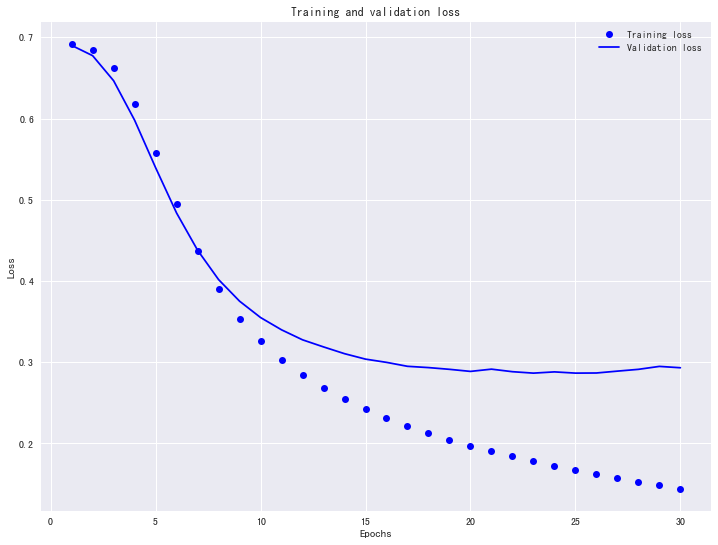

<Figure size 864x648 with 0 Axes>

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

(0.5, 1)

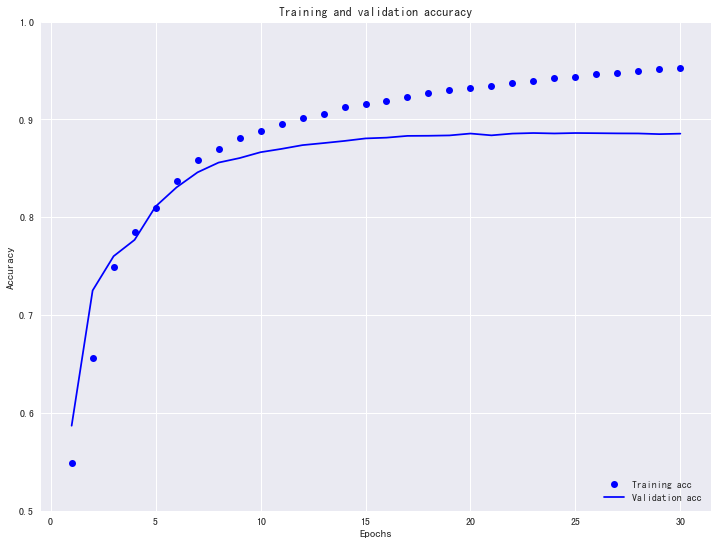

In [10]:
# 准确率和损失的学习曲线
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [11]:
# 回去每个单词的权重
e = model.layers[0]
weights = e.get_weights()
# weights.shape
weights = weights[0]
# shape: (vocab_size, embedding_dim)
weights.shape

(10000, 16)

In [15]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
# Embedding Projector Number of tensors (6721) do not match the number of lines in metadata (6645).

6

197

8

187

6

191

9

199

4

188

4

186

2

189

3

190

3

193

3

191

3

196

3

191

3

180

2

193

5

191

5

193

4

191

3

192

4

194

5

194

6

201

4

193

5

186

3

189

4

177

4

175

4

191

4

189

5

198

3

192

3

197

4

195

4

193

3

200

3

193

3

189

5

195

4

183

3

195

5

189

5

198

4

190

3

195

5

182

6

195

5

176

4

190

4

192

3

184

5

201

6

191

5

181

5

173

5

181

5

184

5

180

3

191

3

182

5

186

4

182

5

182

3

180

6

184

6

189

5

182

6

195

7

202

4

178

6

184

4

195

4

191

5

186

3

187

5

176

5

203

3

187

5

185

5

187

4

179

4

175

5

176

3

186

5

177

5

195

7

192

6

181

6

180

6

170

8

196

4

192

4

177

5

176

6

185

5

193

4

186

5

180

4

180

5

181

5

193

4

184

6

186

4

183

7

190

6

197

6

177

11

192

6

186

4

191

6

197

10

189

5

176

5

187

6

194

5

175

5

181

6

192

7

183

7

184

5

176

5

172

5

186

6

196

4

186

5

198

5

179

4

185

5

197

5

200

7

186

5

189

4

200

6

170

4

192

5

187

6

180

4

197

6

185

6

179

4

182

7

186

3

196

5

185

10

182

8

181

7

185

5

189

4

181

5

180

6

181

9

181

4

178

7

176

8

184

6

182

4

187

6

186

7

182

5

193

3

176

7

183

8

199

7

185

4

190

6

197

8

177

9

188

6

175

9

185

5

187

5

179

6

194

4

193

5

189

5

184

6

181

6

194

4

177

5

182

3

180

6

178

5

181

5

184

6

174

7

176

7

197

6

200

6

178

7

185

4

186

7

185

8

184

6

180

5

187

5

191

4

198

7

179

5

194

8

178

7

195

5

179

8

195

7

179

5

185

4

177

9

186

4

175

7

173

5

196

6

178

8

179

7

176

6

176

7

185

6

184

5

192

5

176

5

185

5

195

6

181

4

184

7

194

12

183

6

180

7

179

5

183

8

191

6

187

4

172

6

186

7

178

4

180

7

182

4

187

9

184

8

181

5

181

5

178

6

178

6

183

12

178

5

194

2

181

9

190

5

186

3

178

5

190

4

179

7

198

3

197

6

170

5

192

4

179

5

178

4

169

5

189

6

181

7

179

5

175

6

179

7

177

7

184

9

177

11

170

4

179

8

186

7

179

6

183

8

181

7

197

7

183

4

184

5

188

6

178

6

196

5

180

10

178

4

186

7

193

6

176

6

181

5

174

6

195

7

173

5

171

6

180

11

188

7

182

6

178

4

171

6

181

6

173

5

185

4

165

5

186

8

178

9

174

8

192

5

195

9

179

6

175

2

175

5

181

8

183

6

177

6

194

8

176

5

199

10

172

5

183

8

191

8

192

9

193

5

181

6

179

6

197

7

199

9

176

5

182

8

184

7

195

5

177

10

161

5

188

5

189

5

187

4

179

5

180

5

176

6

185

5

179

5

182

7

184

5

185

7

191

5

182

7

194

7

188

4

179

5

172

5

194

11

184

6

181

2

177

5

192

5

195

7

184

6

178

5

189

6

198

4

191

4

179

5

205

7

183

4

185

13

172

6

178

8

178

7

167

6

169

5

200

5

180

4

198

5

189

10

185

4

180

11

184

6

181

6

173

5

177

8

176

7

178

6

178

6

185

6

166

6

185

5

179

5

201

9

178

7

186

7

175

6

185

6

190

8

200

4

188

5

183

5

179

10

180

4

188

8

196

10

168

8

176

11

176

6

175

5

195

9

179

8

186

7

190

8

187

8

194

6

185

6

176

5

181

6

191

5

187

8

161

6

181

6

171

11

169

6

177

7

174

7

184

6

185

5

197

7

187

9

183

7

199

5

183

8

180

6

182

5

196

5

184

5

187

4

179

6

171

9

176

6

186

9

176

11

185

6

181

8

192

4

188

8

197

5

181

6

171

10

178

5

197

7

178

6

171

7

181

8

172

5

176

13

170

6

198

3

197

8

178

5

187

7

194

6

173

6

184

3

180

8

184

5

178

7

179

6

184

10

180

7

187

6

184

2

183

10

182

5

183

8

189

8

185

6

185

8

182

7

194

5

180

8

188

6

192

7

180

11

177

2

176

5

184

14

178

7

181

4

176

2

198

9

188

6

181

5

175

8

176

8

169

6

186

6

176

6

172

8

184

5

187

6

176

8

180

8

195

8

188

7

183

6

178

4

191

5

173

6

198

6

174

7

195

6

174

4

198

5

177

5

174

5

194

5

176

2

190

5

176

6

193

6

187

8

188

5

186

6

198

8

169

4

184

6

176

5

199

9

162

5

184

5

187

7

183

10

177

4

185

5

184

4

189

5

172

5

179

8

186

4

194

9

187

9

169

6

187

7

179

10

170

6

174

5

183

11

179

5

183

7

181

9

185

8

196

6

187

6

187

10

186

6

181

7

183

5

183

6

198

7

172

7

199

8

199

6

197

7

174

5

174

7

183

5

180

7

181

4

184

6

184

7

185

6

182

4

182

4

179

5

189

7

185

5

195

6

198

7

183

7

172

7

186

9

197

7

202

4

178

5

180

8

180

13

189

6

179

9

197

9

201

10

184

9

183

8

174

5

192

7

176

7

183

7

182

5

182

6

198

11

179

9

176

10

177

7

181

8

179

2

195

7

183

6

187

7

177

7

175

5

177

4

179

8

192

7

199

5

183

5

177

9

185

9

179

6

175

6

185

4

199

7

168

5

172

3

182

5

202

7

178

7

186

7

179

5

190

9

185

10

182

9

181

6

171

8

183

4

184

8

191

8

187

8

200

6

184

9

184

6

186

9

190

15

191

6

190

6

185

5

185

8

188

5

182

8

182

6

187

8

177

8

204

5

186

7

186

6

168

6

194

6

178

10

172

9

173

6

202

8

189

5

176

11

174

5

190

13

176

5

196

6

193

8

178

7

176

6

180

7

184

7

186

5

177

8

193

6

189

7

185

6

197

8

181

5

179

12

182

6

185

5

180

6

192

7

198

7

191

7

183

6

188

9

169

5

197

10

182

7

185

7

186

5

182

6

181

7

183

8

195

5

187

7

186

5

181

11

183

13

174

7

181

7

181

4

178

5

179

6

185

10

175

10

174

2

163

6

182

8

189

11

199

5

175

8

180

11

185

6

176

4

191

5

195

6

183

8

194

7

174

6

175

6

197

9

176

2

162

6

175

5

201

9

183

7

183

7

173

6

179

6

174

5

179

5

175

6

194

9

176

6

190

14

180

5

172

7

188

5

192

8

193

12

174

7

169

8

180

9

188

9

175

5

191

7

184

6

182

6

180

8

180

10

175

6

181

8

172

5

180

5

173

7

180

7

179

4

177

8

196

7

181

4

198

10

189

8

180

8

181

5

201

6

179

5

169

7

197

7

183

6

183

7

190

2

187

6

180

8

189

5

190

6

178

4

189

6

186

8

173

8

174

4

197

5

178

10

179

10

172

5

172

6

192

6

184

8

175

5

182

5

168

10

170

7

189

7

194

8

194

7

179

5

189

4

181

5

186

7

176

7

197

5

189

6

187

5

176

2

173

9

198

8

186

6

178

7

179

9

172

3

181

8

189

6

169

7

192

8

193

8

179

8

180

7

183

7

180

6

182

6

177

7

181

6

178

5

196

7

182

7

175

5

178

8

178

7

185

5

177

11

171

6

179

4

178

9

180

8

184

10

173

7

199

6

181

6

197

5

182

6

197

4

185

5

182

8

176

2

184

8

184

6

201

9

171

6

203

5

176

9

177

6

199

8

182

8

170

6

185

11

168

5

189

11

178

10

177

9

181

8

171

5

183

4

180

7

180

6

181

5

182

3

201

11

197

5

193

5

177

8

200

8

196

5

199

7

198

9

194

7

196

7

168

8

176

5

175

7

191

9

177

11

168

6

188

9

184

4

188

6

176

8

187

9

208

7

178

8

201

7

174

7

188

10

187

5

183

8

187

11

182

6

207

8

191

3

186

4

194

8

181

7

179

9

196

7

192

7

178

3

194

6

177

4

175

7

176

6

187

5

199

7

164

8

188

5

198

10

177

6

177

6

179

6

184

10

182

9

187

10

176

10

187

8

177

5

187

7

197

5

200

4

193

6

169

4

187

5

188

6

176

6

197

7

184

7

183

4

197

10

177

6

201

8

192

3

189

6

174

8

176

8

181

11

174

8

181

8

180

8

173

6

185

5

174

7

181

5

182

7

177

5

202

8

183

8

181

10

180

6

174

4

193

12

178

9

187

4

184

8

177

5

169

7

183

8

185

10

170

5

190

7

184

4

179

7

182

7

170

8

187

6

184

7

171

7

180

9

184

7

174

7

198

2

199

6

177

9

195

11

189

5

180

5

197

8

185

9

180

8

181

6

187

8

187

6

200

5

174

9

168

7

200

11

180

8

182

11

185

6

189

10

184

7

183

8

178

7

176

10

178

7

182

5

180

6

198

4

186

12

172

4

186

10

196

7

173

5

176

6

171

9

194

8

179

4

174

10

200

3

181

4

186

7

186

7

194

8

190

7

182

8

202

6

185

6

198

8

186

6

195

8

189

5

178

6

185

9

172

5

178

10

172

7

186

8

177

9

183

8

187

4

192

8

177

8

193

7

174

5

179

9

185

9

181

5

181

8

170

7

191

4

198

9

178

7

180

5

177

5

181

8

195

6

174

5

178

6

183

6

188

7

189

5

196

6

176

10

186

10

194

6

169

11

171

7

179

5

182

5

180

7

176

7

171

6

193

9

203

4

183

11

183

6

185

7

173

8

181

7

178

5

175

8

194

8

200

5

182

8

184

8

186

8

186

12

190

5

196

7

194

8

185

6

190

8

200

8

181

9

181

5

189

11

194

9

193

3

187

9

181

8

173

5

181

6

183

5

180

2

180

9

184

3

173

12

178

7

179

6

185

5

191

6

185

9

173

2

182

7

184

9

180

6

180

7

176

6

174

9

173

6

178

7

176

9

175

8

193

6

190

6

183

6

182

7

198

6

184

7

183

11

187

8

185

7

197

8

178

11

182

8

190

8

188

3

186

8

183

6

203

8

189

9

179

7

178

9

179

8

181

9

179

6

189

5

193

6

186

5

183

4

184

9

199

10

173

5

182

7

175

6

195

7

185

8

181

8

200

7

199

6

177

5

189

11

175

8

183

10

168

6

188

2

186

10

170

6

189

6

188

6

196

5

184

10

173

8

182

6

170

6

181

6

182

11

174

8

184

8

193

8

179

5

190

4

198

6

176

7

181

11

192

4

175

8

179

8

181

4

181

7

200

8

182

11

185

10

196

4

180

7

179

12

168

8

186

10

184

8

192

7

173

4

179

9

175

6

193

11

197

8

183

7

185

5

181

8

171

7

179

11

178

11

184

8

195

5

187

7

174

7

185

10

183

4

180

8

180

7

172

7

170

6

183

10

180

9

179

2

181

7

199

5

198

2

185

5

182

6

177

6

191

6

185

5

179

5

179

7

177

8

189

7

175

8

179

9

175

10

185

9

196

5

171

6

179

7

185

6

179

10

185

10

185

6

181

6

179

6

185

6

190

3

197

7

185

9

183

6

174

10

186

13

168

6

184

4

178

12

174

6

178

5

182

8

178

4

197

4

195

7

192

9

181

8

173

5

176

7

179

9

175

11

188

8

184

10

182

8

174

5

188

6

177

6

176

8

188

5

195

7

168

5

201

5

165

6

174

8

183

11

186

9

177

5

180

7

180

7

179

5

182

9

200

7

201

8

170

11

177

6

176

6

184

5

191

7

174

5

164

8

176

6

198

4

199

7

172

8

191

8

184

8

183

5

177

9

179

7

182

5

183

12

171

6

176

7

180

6

192

13

177

6

188

7

174

7

174

9

172

7

171

6

201

5

193

8

177

7

174

9

172

8

183

6

180

5

192

8

170

5

185

6

182

6

176

8

171

7

184

4

190

4

201

8

199

5

178

10

184

10

169

8

181

7

180

9

182

7

176

8

180

7

175

7

197

7

188

2

193

14

168

5

182

7

177

6

177

5

186

7

182

7

177

12

170

9

183

7

181

8

174

11

177

6

176

5

175

5

180

5

184

7

182

9

188

8

176

8

178

9

199

10

179

7

181

5

178

9

167

5

184

5

196

5

172

10

201

8

201

8

181

7

179

7

175

5

167

5

186

9

179

12

187

9

185

7

176

8

182

11

176

8

176

6

185

8

183

7

181

7

194

6

181

11

190

9

175

12

170

6

181

7

177

11

184

8

186

9

187

15

171

6

191

8

177

6

197

10

185

5

186

6

181

8

183

7

186

8

190

11

181

13

186

6

181

4

191

10

179

6

179

6

174

6

177

7

197

6

186

7

178

8

180

8

185

5

186

6

187

5

175

9

187

7

184

4

168

7

183

9

174

8

175

6

202

6

184

5

183

6

181

8

184

7

195

8

184

8

177

8

185

5

195

12

173

9

178

8

179

10

184

6

180

12

193

7

181

9

186

8

179

9

170

10

166

7

185

8

181

5

191

8

188

11

166

4

186

4

192

5

180

10

184

4

189

6

180

8

177

6

178

6

180

8

196

6

185

5

186

5

188

6

176

6

182

5

187

6

185

10

178

6

180

6

181

6

202

5

171

8

204

2

186

6

181

8

173

9

193

8

177

7

183

11

198

8

184

6

168

9

191

6

195

2

179

6

181

7

182

9

188

9

174

8

183

10

181

7

180

5

193

7

171

8

199

9

175

5

183

4

183

4

190

6

179

7

179

8

180

6

178

8

179

10

176

8

182

9

178

3

173

6

169

7

206

11

179

7

196

10

197

6

178

5

187

7

179

5

180

6

187

5

179

6

190

6

184

6

175

7

181

9

176

14

206

5

187

8

180

5

180

5

177

9

180

6

173

7

183

7

186

4

173

9

163

3

179

10

190

6

182

7

184

7

179

10

187

6

190

9

199

4

200

5

177

3

196

5

186

6

183

5

173

6

188

9

174

12

175

5

201

10

177

7

173

9

178

10

180

3

176

10

184

7

176

10

166

8

173

9

181

5

177

5

195

5

176

4

184

11

177

3

183

11

177

7

194

9

175

5

176

9

169

7

184

3

182

6

179

8

197

10

180

8

172

9

187

8

178

9

182

9

174

7

165

7

176

9

178

6

185

5

181

6

175

5

173

7

178

8

185

6

195

7

176

6

193

7

176

7

185

7

180

11

180

7

191

8

172

8

194

5

179

7

178

9

198

6

178

6

180

10

176

2

187

6

184

6

182

7

174

5

172

5

190

7

177

5

190

6

180

12

180

9

191

7

168

10

178

10

191

12

177

8

175

6

175

9

192

9

182

6

188

13

178

5

188

7

175

8

177

6

176

5

179

7

179

8

178

7

173

4

185

9

190

5

174

5

180

7

177

4

192

7

176

10

173

6

177

6

179

5

182

5

181

8

185

5

183

8

183

5

175

8

182

5

186

9

198

6

187

10

174

6

181

6

196

10

183

2

199

8

180

3

183

8

186

8

181

7

174

13

176

9

190

6

199

6

182

8

192

8

198

12

165

10

171

6

190

6

183

3

187

6

171

4

201

9

178

4

186

7

176

7

201

10

194

6

173

6

187

4

184

6

177

7

174

5

178

9

182

8

174

11

180

9

181

3

181

8

191

5

193

6

176

6

192

4

185

6

190

6

195

6

185

5

193

9

174

11

178

6

187

9

179

8

185

9

194

6

183

7

184

8

175

8

193

5

178

6

200

7

191

7

186

7

172

8

182

8

176

6

180

4

199

8

195

6

181

7

183

10

199

12

178

11

174

10

202

6

184

9

182

8

176

12

195

9

178

8

172

5

192

9

184

5

184

10

184

7

180

6

175

11

173

7

186

6

182

9

173

9

175

12

181

2

180

5

197

8

177

9

175

4

177

8

184

4

170

7

174

10

174

8

184

7

172

4

195

7

197

6

180

10

190

9

190

8

184

7

179

8

189

9

185

7

169

8

178

11

166

8

189

9

196

7

182

5

179

7

177

8

201

11

181

7

179

6

192

6

179

6

182

7

186

7

177

8

190

4

195

5

182

7

186

6

170

8

179

7

185

5

180

8

178

8

180

8

181

3

174

10

188

7

184

7

190

5

177

8

175

5

191

7

182

6

174

5

185

5

185

6

180

6

188

4

174

7

180

8

180

5

177

8

185

8

190

6

182

6

176

9

183

8

187

4

178

9

183

6

198

5

182

6

196

5

180

6

176

11

176

12

178

10

177

9

186

6

175

7

172

6

181

4

176

10

181

8

171

9

180

8

178

6

189

9

179

4

191

5

195

5

183

8

195

7

199

7

191

6

178

9

180

5

182

6

182

7

176

6

184

7

190

6

176

8

199

5

195

10

180

7

176

5

182

9

172

4

173

10

184

6

169

8

178

7

190

9

193

11

171

9

174

7

176

5

191

6

183

5

199

5

185

7

183

6

172

5

195

6

189

6

178

9

188

8

187

5

197

6

183

6

173

3

183

5

188

8

178

8

178

9

179

5

184

7

174

8

201

6

180

6

199

7

197

10

182

7

170

8

179

12

185

6

183

8

176

6

185

14

180

6

181

8

181

4

189

8

179

5

203

4

176

6

177

9

168

7

177

7

180

6

176

8

178

9

173

6

199

7

184

5

187

7

176

6

178

8

178

11

171

3

177

6

199

6

171

7

174

4

181

5

178

5

179

8

174

9

195

7

181

7

177

7

196

10

177

7

173

6

192

5

180

7

190

5

183

5

197

5

180

8

171

9

179

6

193

5

186

9

189

8

180

9

184

9

188

9

175

10

183

12

174

5

189

7

182

8

176

5

181

8

178

6

189

8

178

8

178

11

178

10

183

7

193

8

170

9

174

7

183

7

198

2

187

4

177

14

180

6

199

5

179

4

186

6

185

12

191

8

198

8

183

9

176

8

203

7

182

7

185

6

184

10

182

6

187

9

190

5

197

2

182

9

196

9

185

8

179

14

178

8

172

10

184

9

180

5

197

2

187

7

186

5

184

4

179

5

179

8

195

5

194

10

173

12

174

3

186

6

187

9

182

9

168

6

171

7

178

8

176

8

181

9

181

7

189

10

180

8

182

6

197

2

186

4

179

6

176

7

177

6

183

4

184

5

186

7

192

5

175

2

170

9

182

11

185

5

178

12

180

8

199

9

177

11

199

6

192

11

181

6

175

6

185

8

178

13

175

7

179

8

183

7

174

12

172

8

191

6

177

9

175

12

175

8

187

4

197

8

182

8

202

5

180

7

179

8

173

8

176

6

183

7

201

6

193

6

176

8

176

9

179

8

181

7

184

8

190

6

180

8

184

6

191

7

193

6

174

7

176

7

189

6

198

10

178

6

189

11

200

10

185

5

187

6

176

11

174

6

183

6

201

11

182

7

192

8

185

9

192

5

189

4

190

7

195

10

188

7

199

5

167

6

188

9

202

6

184

7

187

12

168

8

184

9

176

11

185

9

176

4

176

6

186

9

182

6

190

7

184

7

175

8

173

12

167

7

178

6

182

5

192

9

183

6

185

7

201

9

178

6

185

6

199

6

197

7

197

7

177

12

185

5

179

6

179

7

197

6

180

5

188

9

170

6

183

8

178

5

174

7

176

9

195

4

183

11

178

10

188

7

185

4

184

5

173

7

176

5

176

5

181

9

189

7

193

5

180

9

180

7

193

5

187

7

181

6

180

10

179

12

196

10

176

9

176

6

173

6

173

11

191

9

175

5

195

7

183

6

178

6

177

9

197

5

189

6

179

5

197

6

183

7

177

5

177

9

190

7

197

7

170

9

183

6

178

6

199

11

185

7

181

7

189

5

175

12

198

8

199

4

176

8

181

8

179

5

196

6

180

11

181

11

172

13

173

6

192

8

175

6

180

8

192

5

183

7

179

9

203

8

174

5

176

10

176

8

186

8

174

7

179

10

185

5

186

12

198

6

176

8

173

8

171

6

175

9

182

5

175

5

184

10

185

4

193

9

175

5

180

8

192

5

173

9

180

7

188

10

173

7

187

6

186

8

189

12

186

5

183

4

184

5

173

5

192

4

189

11

174

13

188

8

181

8

199

8

183

7

183

5

177

7

178

9

200

7

191

7

181

7

180

9

179

5

185

2

176

8

182

7

180

9

178

4

174

5

182

5

181

11

191

8

179

8

187

9

193

9

184

11

193

7

181

7

178

8

179

7

189

9

180

12

179

7

186

7

184

7

175

6

201

10

176

11

175

5

175

11

189

13

180

6

173

12

176

7

174

5

179

7

172

7

174

6

187

10

182

5

190

7

181

11

181

9

179

7

196

12

188

7

176

6

183

3

202

7

177

8

176

9

172

8

182

9

187

4

178

6

187

6

199

8

178

2

201

8

199

6

175

8

182

9

168

6

178

9

184

5

192

9

195

5

188

10

190

5

177

5

182

6

189

6

181

6

201

12

198

5

178

5

174

9

199

7

182

12

168

11

177

11

181

9

193

6

172

8

179

5

175

7

176

9

182

7

181

6

178

10

184

7

205

8

175

8

173

14

192

8

178

9

204

9

181

5

190

7

199

6

191

7

189

8

182

6

185

9

192

11

180

9

194

6

177

7

174

9

172

10

187

8

181

11

168

7

195

7

195

5

181

5

174

7

167

8

177

4

204

9

180

6

193

7

179

10

181

9

170

6

184

10

185

7

184

5

182

4

174

7

179

8

175

10

191

5

177

6

183

6

178

10

184

8

183

11

176

7

172

5

176

8

180

11

179

8

179

5

179

7

179

7

187

7

180

9

183

11

182

5

198

9

195

5

197

8

177

5

181

13

186

6

176

5

181

7

195

5

187

6

181

10

177

9

187

8

186

7

201

7

182

10

176

4

196

8

184

6

169

6

194

7

180

5

188

8

193

12

181

8

183

8

191

8

174

7

195

7

183

9

184

5

192

6

185

9

185

5

191

9

192

9

183

8

192

9

171

9

171

8

176

10

186

9

180

7

181

4

179

10

190

7

171

11

161

11

177

7

185

3

176

10

181

7

174

5

180

12

168

8

176

7

178

8

184

7

174

5

179

6

185

9

197

5

192

6

187

6

199

7

183

11

194

6

184

6

171

7

195

5

183

8

182

10

178

10

194

7

176

8

179

11

173

6

184

7

183

7

193

13

178

10

186

8

198

6

175

6

188

8

192

9

202

11

199

7

174

3

198

6

173

8

182

5

195

8

181

8

171

8

177

11

175

7

187

6

179

6

192

6

177

5

188

10

180

12

174

7

182

6

185

8

185

6

170

7

200

8

186

9

184

7

188

8

183

8

184

6

169

14

177

9

189

10

196

9

199

9

183

13

181

4

181

8

175

6

176

7

174

8

198

9

182

5

187

5

183

5

195

5

197

9

194

11

179

6

178

6

185

9

180

7

182

5

191

12

168

10

176

9

182

9

179

7

179

8

197

6

193

12

181

9

185

10

197

7

182

12

185

10

175

7

191

5

178

6

195

6

191

7

172

6

183

4

182

4

184

9

183

8

183

9

186

9

177

11

182

4

178

11

195

7

182

6

194

9

199

6

192

8

185

8

186

10

199

10

178

9

181

9

168

6

178

8

181

6

176

10

179

6

195

9

186

6

186

12

170

8

191

6

177

7

195

12

187

9

174

10

168

11

189

7

196

5

166

6

181

8

192

5

176

6

181

9

186

7

184

7

188

11

176

8

175

6

192

10

186

6

190

7

181

8

178

9

182

6

177

7

171

7

193

7

184

13

179

6

197

9

183

9

176

10

175

7

201

8

190

6

176

7

181

6

175

8

191

7

167

7

188

10

182

7

180

4

179

10

189

10

181

7

184

8

199

6

171

12

173

10

190

6

181

8

181

7

175

6

184

8

180

9

177

10

179

7

183

8

177

13

179

5

181

6

182

11

178

10

173

4

184

5

198

6

178

6

173

11

187

5

204

11

187

5

181

7

179

12

185

9

184

4

177

7

179

6

178

8

189

6

191

10

196

4

178

6

180

10

174

8

190

7

178

7

196

8

176

8

197

7

183

8

184

12

189

7

182

6

183

6

178

9

180

7

186

9

186

11

176

5

169

8

179

5

179

7

185

7

180

6

183

6

176

9

179

8

175

3

189

12

186

6

193

6

179

8

191

9

177

6

173

7

185

4

173

6

174

7

177

5

194

6

188

7

179

7

182

6

189

5

177

4

176

6

182

8

186

7

175

7

187

6

179

6

178

10

184

6

195

6

173

12

179

5

183

4

183

7

172

8

182

7

187

7

173

6

177

8

180

6

189

11

172

7

197

8

182

9

175

10

175

8

192

6

185

12

176

6

170

9

176

6

174

10

167

4

181

10

185

4

198

12

178

6

176

6

183

8

185

5

184

9

201

7

183

4

180

8

180

7

178

6

188

5

178

7

173

7

184

8

177

6

191

9

186

14

180

7

176

5

181

7

177

8

181

7

182

9

182

7

186

8

177

7

180

3

177

8

178

10

178

8

182

10

186

10

203

9

183

3

181

5

186

5

178

9

189

7

192

5

190

13

180

6

194

8

183

9

194

12

197

5

181

9

174

9

185

5

201

12

188

5

185

8

186

7

187

7

184

12

177

6

183

7

184

10

187

5

183

7

177

7

199

10

180

10

178

10

176

6

184

6

178

8

179

9

188

5

197

7

178

14

176

7

180

13

189

8

182

6

196

8

183

6

198

7

178

5

183

10

170

7

167

9

193

7

190

7

184

6

182

7

171

7

183

10

196

8

178

4

178

7

174

10

181

10

178

9

184

7

194

11

184

5

183

5

201

8

179

8

204

6

187

7

186

12

182

5

177

10

178

8

176

6

194

10

185

5

182

7

185

8

167

11

182

7

184

6

188

11

200

10

174

9

189

8

185

7

185

9

188

7

167

6

176

7

190

7

180

9

184

6

182

8

178

10

183

9

174

9

191

12

182

7

172

4

200

6

176

4

181

12

186

7

184

5

179

10

195

13

182

8

185

6

190

5

186

8

201

9

173

13

173

8

181

8

180

9

171

5

185

8

171

5

193

7

180

7

188

10

179

9

193

4

196

9

168

7

179

7

176

10

176

7

184

7

188

6

195

8

187

7

196

6

195

6

182

7

181

4

176

10

177

7

180

7

189

9

175

7

181

6

177

10

167

7

192

8

205

7

194

10

191

7

184

6

178

7

189

4

182

7

183

9

203

7

172

7

177

12

199

4

177

8

181

5

196

5

179

6

187

9

177

7

202

9

188

11

182

4

176

10

178

6

178

10

176

12

179

6

185

8

185

8

170

5

186

5

178

7

183

12

175

9

179

5

182

5

178

5

182

11

185

9

183

8

182

9

180

10

187

7

193

6

175

7

173

10

190

15

175

8

173

5

201

9

182

5

188

9

180

5

186

10

171

9

198

5

180

6

185

5

185

6

184

5

187

10

200

7

186

8

173

5

200

6

199

9

179

13

184

5

178

13

176

13

177

6

179

7

178

9

178

6

198

5

189

9

193

4

180

8

179

6

190

6

189

6

176

7

194

10

202

9

188

12

176

6

175

10

172

4

195

11

182

5

185

9

183

8

179

10

176

6

177

5

177

8

183

8

169

4

178

6

177

7

183

8

197

6

176

6

178

8

182

7

182

7

171

9

184

10

182

5

197

11

182

5

175

6

174

11

192

6

185

4

184

8

183

7

174

7

200

7

176

5

176

6

184

8

185

7

175

10

203

8

184

9

187

6

192

8

168

8

178

6

183

4

183

6

199

3

185

7

175

7

180

5

176

12

173

10

184

7

176

9

166

7

183

14

183

7

183

7

180

9

179

8

175

8

179

7

185

8

178

12

177

7

193

7

191

6

177

6

174

6

195

6

183

4

195

5

179

7

182

6

176

3

189

8

179

6

195

5

176

4

187

5

177

5

182

9

177

9

203

10

185

8

184

5

184

5

177

9

182

9

186

7

196

10

180

5

178

7

186

7

177

5

177

9

186

8

179

10

175

6

176

6

177

5

175

8

174

9

184

9

179

6

198

5

179

5

180

9

180

6

179

11

186

10

169

5

178

5

173

6

178

8

180

4

188

7

178

4

185

6

185

8

180

14

179

9

179

5

197

4

189

10

176

8

181

8

186

8

187

10

184

10

175

8

198

8

178

9

192

10

201

7

176

4

183

8

177

9

169

8

175

10

181

7

174

9

172

9

185

8

191

8

175

5

210

6

177

6

205

7

174

8

180

5

186

10

174

14

186

9

193

5

177

12

187

9

182

7

181

8

191

5

193

5

183

5

184

8

168

6

177

12

167

8

177

6

189

6

188

6

174

10

175

7

196

8

184

10

197

6

174

6

174

8

197

5

186

6

187

6

181

5

179

6

184

6

181

12

176

6

176

5

185

6

174

8

182

6

187

6

188

11

188

8

184

8

199

9

193

7

178

5

186

11

187

8

182

6

184

6

178

7

182

7

192

5

193

6

184

5

180

8

181

7

180

9

178

11

178

8

172

6

186

9

172

9

199

7

187

9

177

14

165

9

185

6

180

9

162

5

175

6

179

7

201

10

193

8

197

8

184

6

177

9

174

8

179

7

175

11

185

10

185

8

177

7

174

7

185

7

179

6

173

9

186

5

179

8

188

7

190

5

178

7

187

6

176

13

177

4

176

11

173

6

176

7

176

13

186

8

191

3

182

8

198

9

183

3

183

7

179

6

192

8

176

8

178

3

180

5

192

6

186

10

200

7

168

7

184

6

181

7

199

5

196

8

174

12

192

7

180

11

177

8

177

11

185

12

180

10

184

6

172

5

180

7

176

5

180

4

184

10

202

9

196

9

189

7

170

5

171

8

202

3

185

6

186

8

173

4

188

6

173

6

188

7

173

4

194

7

176

5

197

5

188

6

195

3

181

11

183

6

179

6

180

8

173

9

174

7

183

10

178

9

181

4

186

9

171

8

180

7

171

10

172

5

176

10

178

9

171

6

183

9

185

7

175

6

182

7

176

9

186

11

173

8

185

8

200

8

175

8

177

6

175

9

181

8

180

7

187

5

175

7

186

7

178

5

179

12

176

6

199

6

199

4

184

3

181

9

172

7

188

6

184

8

182

8

184

6

175

5

174

6

192

10

184

6

197

5

194

8

176

8

181

9

197

4

187

5

179

8

175

7

176

4

182

8

177

10

183

8

185

10

188

10

170

6

183

5

179

7

176

6

183

11

187

2

189

7

197

7

174

7

173

10

184

11

188

3

184

9

193

6

186

8

179

10

178

4

182

9

183

9

182

10

180

7

181

7

186

7

174

8

183

7

186

9

184

4

188

7

190

16

183

7

174

11

178

12

180

7

184

11

180

12

198

10

174

8

178

11

173

10

180

11

189

10

173

5

185

5

186

5

177

9

190

7

186

6

193

6

176

5

183

6

180

8

177

5

176

6

185

11

181

8

184

9

187

6

186

6

177

8

192

9

177

6

201

5

179

7

202

11

186

5

179

8

178

10

179

7

177

7

187

9

179

7

185

6

180

9

195

7

194

8

178

6

183

6

183

9

190

11

178

13

195

4

180

9

167

10

175

7

194

7

187

9

173

8

202

11

183

8

182

6

183

4

194

7

193

5

182

9

180

6

185

7

180

7

201

11

181

9

184

7

202

3

175

7

181

8

188

8

189

11

174

6

178

9

181

6

183

8

178

4

186

9

180

6

188

5

179

6

197

11

182

11

183

4

179

10

198

7

196

6

193

8

191

6

178

7

183

9

181

6

181

6

193

9

185

5

181

6

182

8

181

8

180

7

178

7

192

4

192

5

173

6

183

11

170

14

178

8

194

8

197

9

174

11

191

14

196

10

177

7

174

10

177

7

189

10

179

8

173

8

195

6

184

6

188

6

186

11

184

8

181

8

183

7

186

10

183

8

194

12

187

10

199

7

185

6

183

8

176

11

172

8

188

5

181

6

199

6

184

7

197

5

188

7

178

4

182

10

195

11

183

12

176

6

197

7

191

8

181

8

179

7

181

11

168

6

180

9

202

8

180

7

184

6

185

10

177

6

191

8

173

10

187

5

186

9

170

13

181

10

181

9

177

7

183

7

196

12

181

7

168

15

184

9

171

7

187

5

181

9

170

11

178

6

167

9

199

4

184

5

181

11

181

7

178

8

188

11

186

7

174

11

183

12

178

8

186

7

198

10

175

4

194

3

195

10

187

7

198

10

188

8

199

7

172

4

183

7

199

5

186

17

183

8

181

7

190

9

176

7

175

4

194

6

180

11

174

6

191

9

184

3

185

11

193

6

168

9

192

7

184

12

176

13

174

10

178

7

174

7

186

9

180

8

176

6

184

11

180

8

201

8

201

11

174

13

169

10

183

6

175

7

192

6

167

9

177

8

183

9

199

7

186

10

195

5

192

6

193

5

198

6

192

6

178

8

184

8

182

8

186

8

200

7

179

5

191

5

181

7

174

10

175

9

175

5

195

10

182

7

178

8

191

4

177

8

178

5

195

4

184

5

179

9

196

13

187

6

174

6

178

4

197

6

179

5

187

10

172

8

179

11

176

7

172

11

184

8

180

4

173

5

178

8

176

10

187

11

180

12

192

12

179

9

183

7

181

8

177

14

201

7

172

7

184

6

177

5

184

8

183

5

183

9

167

7

178

7

191

6

184

8

183

9

168

6

185

6

191

10

176

5

182

5

180

6

177

11

174

6

197

5

187

12

184

5

188

9

183

8

185

10

195

8

183

10

188

9

185

13

175

8

179

10

195

4

182

5

177

5

176

10

176

3

186

5

186

6

184

10

190

4

185

8

196

8

177

11

182

9

179

8

181

5

183

8

181

8

188

8

196

7

184

9

184

6

181

12

174

11

196

4

179

6

185

6

194

12

194

4

196

6

187

6

191

8

182

6

183

7

180

6

187

8

179

6

198

6

186

8

175

9

194

9

182

8

178

8

174

8

178

8

181

11

191

9

187

10

189

6

178

8

189

10

180

7

187

11

179

9

192

7

180

9

169

10

180

10

179

7

178

4

183

8

184

10

172

7

181

4

190

7

177

7

181

7

186

6

171

11

200

8

188

4

177

7

177

8

185

9

168

7

170

7

183

7

181

7

183

9

198

10

180

7

178

6

171

8

171

9

181

8

200

6

176

7

199

11

177

9

193

11

182

7

204

3

184

6

179

7

174

6

176

7

189

7

175

8

176

10

176

6

193

9

190

5

176

7

179

8

180

10

193

11

171

9

185

8

182

6

176

13

179

6

184

5

175

3

175

5

181

7

175

8

187

8

178

3

181

13

180

8

176

9

171

6

178

6

184

9

201

11

178

7

176

10

187

5

203

5

178

5

177

5

182

4

187

7

177

12

204

11

179

8

184

5

181

6

181

7

175

7

181

9

186

8

201

6

189

8

178

6

191

8

173

6

174

10

187

13

184

12

184

7

196

12

194

9

189

7

197

6

181

10

195

9

183

7

172

8

195

9

186

7

205

7

190

12

186

7

175

9

177

9

184

9

184

7

194

6

184

7

176

6

182

10

179

8

185

10

185

5

170

10

176

10

196

10

180

6

196

5

182

6

191

4

183

5

197

10

188

6

181

9

178

6

180

2

195

11

186

4

170

7

181

11

188

7

177

6

204

8

178

6

181

4

175

5

179

11

184

12

183

8

199

7

178

9

187

8

175

8

176

5

188

8

176

8

180

8

181

6

184

6

197

7

186

6

192

7

184

6

183

7

202

12

181

8

194

7

180

8

181

6

182

5

179

5

183

9

182

12

176

7

183

5

176

13

178

4

178

10

185

5

196

9

177

6

184

7

169

10

180

5

192

6

192

7

184

5

189

7

189

11

186

8

196

9

183

7

194

7

186

7

180

6

185

4

179

9

180

8

184

8

180

9

184

6

183

8

176

14

196

6

181

8

177

8

177

9

179

10

186

5

178

8

186

5

179

4

197

6

177

12

172

6

177

9

182

11

200

6

181

7

177

4

178

8

187

8

175

11

172

4

183

5

194

13

173

5

183

6

171

9

183

7

196

5

184

10

193

8

178

7

195

4

194

9

201

9

172

5

192

10

192

5

181

6

191

7

178

5

193

8

185

7

176

8

180

4

168

5

182

7

182

6

183

7

183

5

177

7

181

11

179

8

180

8

185

9

199

7

181

10

194

5

182

9

180

6

179

6

173

7

187

6

178

5

180

7

183

7

186

8

184

8

186

8

184

6

179

13

175

7

194

9

175

10

187

7

183

5

184

7

177

12

183

11

185

10

190

10

198

10

198

5

192

10

177

13

196

7

174

6

183

12

180

9

179

5

200

12

176

8

173

6

180

8

186

8

194

12

179

9

185

7

193

7

198

11

190

11

196

8

178

5

173

11

171

6

183

12

170

12

174

10

182

7

183

12

188

4

186

7

185

5

186

7

182

14

175

10

176

9

172

12

189

8

180

10

194

10

174

6

177

6

198

7

186

8

178

9

178

6

197

9

207

7

180

9

176

4

205

5

197

7

178

6

176

6

185

5

199

8

190

10

177

4

183

7

193

9

175

7

181

12

177

8

177

10

178

12

184

5

200

5

186

8

191

7

198

7

196

6

177

8

182

7

183

6

186

6

199

8

178

6

184

7

182

6

181

10

189

9

176

6

185

11

179

7

188

8

185

5

177

8

193

5

192

6

189

8

199

9

183

9

185

5

186

8

180

9

185

7

199

6

196

8

177

6

178

11

184

8

179

8

193

6

178

5

179

6

180

8

179

10

179

7

179

7

180

9

179

9

175

11

176

7

199

13

187

5

182

9

183

9

186

6

175

9

183

8

184

8

199

8

186

8

187

7

188

10

178

10

174

7

177

8

182

10

183

6

188

6

196

7

175

8

180

6

172

8

185

6

188

5

197

7

179

7

186

9

177

7

181

10

195

8

173

12

184

8

191

7

179

12

188

8

173

9

183

6

188

8

199

8

178

4

189

9

184

7

201

6

201

5

176

7

175

9

176

14

190

6

190

6

174

9

174

8

180

7

184

8

194

8

198

5

181

6

178

9

198

5

191

10

179

9

186

6

194

10

196

6

187

6

169

8

177

5

178

8

187

5

186

6

178

10

191

5

175

6

169

8

173

7

186

8

179

12

182

4

185

11

174

4

186

8

178

4

183

10

178

7

179

8

184

10

177

10

179

5

183

6

200

11

194

9

187

6

184

9

179

8

172

8

177

7

190

10

196

8

200

10

182

5

193

8

181

7

169

7

175

3

184

8

174

8

185

7

170

5

170

8

181

12

185

8

165

8

197

8

182

5

201

10

187

6

187

7

190

9

183

7

179

10

182

10

177

4

194

4

176

11

180

8

195

9

170

9

180

9

176

9

181

5

178

12

185

13

186

5

202

10

187

4

177

10

175

5

174

9

178

6

184

4

183

7

183

5

179

10

180

3

182

6

191

5

199

5

185

10

191

4

169

7

179

5

177

5

182

6

175

5

179

8

188

11

178

6

179

7

185

10

183

8

193

5

198

6

187

8

194

4

177

7

185

7

181

7

191

5

180

11

181

6

189

5

173

6

177

9

189

6

176

7

187

9

169

10

186

7

176

8

194

10

183

14

182

12

195

11

175

7

177

8

182

7

176

8

193

15

176

10

196

6

184

7

186

10

187

8

184

8

178

14

182

7

186

12

179

9

183

4

188

7

187

13

182

6

174

11

173

10

180

7

186

8

178

5

175

10

192

12

196

4

175

14

181

5

188

11

179

7

191

7

185

8

181

9

203

6

187

7

179

6

180

5

179

11

188

7

187

8

179

11

185

7

184

10

182

6

179

10

190

7

187

4

174

7

181

9

182

6

181

7

177

6

189

11

193

7

197

8

186

6

179

5

176

8

177

5

183

15

181

12

203

13

190

6

194

6

181

6

177

6

181

8

179

7

176

4

190

8

192

7

174

7

182

9

179

8

177

9

176

7

171

11

185

10

177

9

181

7

175

8

172

7

183

10

189

4

177

9

198

6

182

10

178

5

173

5

195

5

178

3

196

5

197

8

199

10

184

6

188

6

190

7

180

7

168

10

196

8

191

8

193

7

180

6

176

9

178

6

175

4

178

7

176

11

177

7

175

5

197

6

196

16

199

9

176

8

193

5

183

11

186

9

179

10

201

7

179

11

179

8

185

7

178

9

184

7

178

7

196

7

195

5

177

10

182

7

183

6

197

7

194

7

186

14

178

11

180

5

193

11

181

9

183

10

193

9

186

5

181

6

199

4

186

4

173

7

188

5

203

3

184

12

191

5

191

7

175

12

180

6

174

7

177

8

175

8

191

7

186

4

186

9

177

7

183

3

202

12

186

7

183

9

186

4

175

11

204

6

176

6

196

5

186

11

191

7

186

6

187

6

181

5

177

7

199

10

200

3

181

5

183

6

184

8

178

9

178

8

177

11

177

8

180

7

180

6

185

9

173

7

179

13

172

6

178

5

172

6

198

7

172

7

186

3

187

13

194

6

194

8

178

8

182

10

182

9

183

3

196

6

180

9

193

8

180

6

195

6

181

10

203

10

188

9

181

2

191

10

200

5

190

10

173

7

184

5

178

9

195

8

183

9

199

8

174

10

175

9

184

5

181

6

192

6

177

7

177

7

171

9

184

8

177

8

182

8

177

7

182

8

185

9

196

6

178

6

178

8

172

6

200

5

177

5

178

7

182

8

186

6

183

9

180

9

186

8

184

10

197

8

184

9

189

11

180

5

178

7

189

4

173

5

182

6

184

7

172

8

182

7

179

6

181

11

173

12

184

11

173

8

179

7

184

6

183

7

182

5

184

7

191

6

196

7

178

7

196

3

195

7

176

8

180

8

178

11

185

3

180

3

186

5

176

13

186

8

196

9

185

8

178

12

183

7

187

8

189

10

201

8

184

7

185

7

197

6

177

10

175

7

186

6

179

8

193

13

199

6

188

8

175

8

191

10

183

8

181

7

178

10

181

7

185

12

176

12

178

9

174

11

183

8

193

10

177

10

178

8

180

14

202

12

180

5

174

10

186

8

190

14

180

7

196

10

192

9

178

5

183

8

187

8

185

7

183

6

196

7

184

10

185

8

176

10

182

5

199

6

178

12

185

7

179

8

191

6

188

7

184

7

170

9

180

7

181

8

179

9

192

7

179

5

202

9

169

11

175

5

189

9

173

6

200

10

192

7

185

10

178

7

185

7

194

8

187

10

191

9

205

8

179

9

174

7

202

9

175

7

191

5

176

8

193

10

179

5

183

4

179

6

183

8

185

9

192

7

185

9

194

5

181

6

186

13

179

8

185

17

177

9

193

6

185

8

183

7

197

11

177

7

190

9

170

11

192

9

184

9

203

4

179

7

199

8

173

8

179

8

190

10

173

7

180

9

187

5

178

9

180

11

184

10

175

5

176

11

176

7

176

11

190

12

181

5

184

5

185

12

187

5

175

7

180

13

176

9

176

10

187

8

195

7

182

13

176

7

182

8

175

7

193

10

202

10

192

6

175

9

191

7

179

15

182

9

187

8

197

6

186

10

174

5

181

9

180

9

177

7

178

5

183

9

190

12

178

6

176

8

182

6

178

5

179

8

178

4

198

8

177

5

186

8

179

5

183

4

187

8

185

7

183

7

180

7

177

8

169

10

199

10

200

8

190

8

176

9

187

6

195

6

187

8

178

11

174

11

189

5

173

4

171

10

176

8

177

11

187

10

183

10

194

6

177

8

184

7

200

8

179

11

176

5

184

8

196

9

181

9

188

12

176

6

178

8

177

9

180

5

198

9

178

9

177

9

184

7

177

8

200

5

180

5

182

13

179

3

198

8

179

6

195

6

184

5

184

10

178

8

193

7

177

8

183

7

172

6

171

6

197

9

203

6

175

8

178

7

199

4

181

6

183

7

186

8

177

14

185

4

194

4

186

6

190

11

182

6

176

7

197

6

181

9

187

9

186

8

178

11

185

9

201

8

181

8

184

11

179

10

181

9

181

5

180

9

185

7

180

8

181

9

183

8

177

4

196

8

181

5

176

7

181

8

182

11

186

8

175

8

200

5

193

6

193

7

178

7

185

8

180

8

186

7

190

4

178

6

180

9

169

8

176

10

180

7

194

6

173

4

195

13

177

10

199

4

183

12

179

5

174

4

177

7

186

6

173

8

195

9

180

8

186

9

177

9

178

4

186

5

197

7

194

9

176

5

178

11

178

9

180

7

193

4

181

10

194

7

174

6

184

5

184

8

171

8

175

9

174

10

184

10

182

7

191

6

179

7

181

8

177

8

198

6

198

9

176

7

184

6

179

9

178

9

184

5

181

5

175

7

187

9

184

10

187

7

185

6

203

5

196

7

196

14

186

6

177

9

180

9

184

10

184

6

186

7

182

7

187

6

194

11

183

6

196

9

181

8

184

8

199

9

188

7

198

7

177

10

182

6

191

8

177

10

172

6

186

11

192

10

180

12

193

9

184

7

177

5

178

8

194

6

175

5

180

8

178

10

199

7

185

7

185

6

175

10

185

6

178

5

181

6

178

11

177

11

177

11

189

8

176

7

193

8

187

5

196

9

172

9

189

13

182

5

189

7

174

10

181

9

177

9

176

7

199

8

189

5

186

7

174

10

185

6

196

8

185

5

189

10

173

13

179

10

183

10

186

8

191

6

179

5

178

8

178

4

187

12

184

6

189

8

199

5

169

7

170

7

176

8

199

6

177

11

179

8

185

8

180

12

177

10

184

9

187

8

176

7

179

11

179

4

185

8

171

14

175

8

185

9

182

9

197

7

184

10

176

7

171

10

177

5

186

10

185

5

176

10

201

10

197

10

179

8

173

5

195

11

169

7

192

2

181

6

190

9

178

4

182

11

188

6

178

5

193

5

184

10

200

9

183

5

194

7

190

10

183

9

182

11

184

5

191

8

188

10

198

7

192

11

185

4

193

7

187

7

177

4

182

9

190

7

175

7

178

7

172

7

182

8

196

5

185

8

180

10

197

5

185

9

188

8

173

8

187

8

177

6

187

6

176

7

187

13

187

7

189

7

179

5

189

10

178

8

201

8

171

7

199

8

195

9

177

5

187

9

179

7

187

7

177

6

179

7

196

12

175

7

174

4

177

8

189

12

189

5

173

5

177

11

198

6

184

9

182

5

196

10

176

8

182

6

182

5

176

12

179

10

192

9

192

5

194

5

188

14

204

8

180

12

191

7

175

7

186

11

178

9

183

5

196

2

188

8

196

9

174

2

196

8

185

5

187

13

183

7

175

4

172

11

186

8

185

9

183

10

184

13

178

12

169

10

185

12

185

11

185

5

194

6

177

5

178

7

197

10

183

10

179

6

195

6

178

9

183

7

179

10

185

6

185

5

186

9

174

13

175

9

185

9

178

5

181

8

184

7

184

7

176

6

173

8

177

8

195

6

178

9

193

8

182

12

189

7

179

5

183

11

186

7

185

6

177

8

193

7

198

6

195

15

198

7

184

6

172

5

178

8

177

9

174

9

181

9

184

9

191

5

175

5

179

8

170

13

179

10

177

6

178

12

181

10

178

6

168

6

172

5

182

7

197

10

198

9

196

8

190

7

178

6

178

5

180

14

181

7

179

9

175

8

185

8

177

6

185

6

176

5

181

6

182

6

182

7

195

9

176

6

181

9

181

7

186

7

180

14

200

7

188

6

198

11

206

7

183

6

196

13

185

9

188

4

182

4

174

8

184

10

176

8

180

7

182

9

196

10

171

10

179

12

182

5

180

11

197

5

191

7

191

5

177

8

180

7

185

8

180

6

172

8

177

7

183

7

182

5

185

7

181

7

180

9

177

11

179

11

192

7

183

5

189

6

184

4

184

8

170

6

199

6

198

6

188

8

188

6

184

6

179

13

181

7

180

13

181

5

195

11

179

3

181

5

192

5

176

6

180

12

201

5

181

8

185

8

187

9

184

11

174

7

181

12

175

10

185

7

178

12

174

10

178

8

177

10

186

11

182

7

175

7

190

6

184

10

186

6

181

9

178

7

175

8

178

6

180

10

177

6

189

9

183

6

176

10

207

6

177

9

190

8

180

9

196

11

187

7

181

10

180

7

174

7

178

5

178

16

182

11

184

7

177

10

188

9

185

5

178

9

197

8

175

7

171

12

193

7

181

5

186

8

202

9

188

8

188

8

178

9

187

8

185

7

173

13

176

14

183

10

171

7

182

8

204

6

174

10

183

7

201

7

176

8

186

7

178

8

175

3

181

9

175

7

181

8

199

9

186

8

179

7

188

8

179

5

184

10

187

8

184

12

176

5

178

6

184

9

181

9

186

8

183

6

177

7

184

7

187

10

180

5

199

11

198

11

181

4

183

9

182

5

184

8

182

8

191

5

183

7

182

10

184

5

191

7

201

10

175

5

189

11

191

5

189

7

170

6

174

7

180

7

182

13

180

10

178

11

201

8

198

7

177

7

187

7

203

11

174

6

200

8

182

7

196

7

184

7

180

8

188

9

171

6

178

9

190

9

200

5

189

9

194

10

183

7

184

5

172

12

177

10

186

7

185

7

182

8

176

9

178

11

174

9

188

6

184

5

193

7

175

6

172

4

182

6

186

9

174

3

177

5

188

5

189

3

192

7

202

5

176

6

179

9

196

8

175

9

183

14

172

10

176

7

186

3

182

7

179

7

182

8

178

9

171

11

182

10

182

4

181

11

184

6

184

11

191

6

182

10

185

6

191

9

184

6

176

5

188

7

189

7

174

9

177

9

188

3

177

10

187

5

176

5

191

8

181

5

184

6

177

6

183

4

177

10

181

9

186

6

187

4

200

10

181

9

184

8

189

11

188

11

173

4

202

8

189

15

196

7

180

9

184

6

176

5

183

5

177

9

178

10

176

8

178

9

198

6

173

5

186

6

180

6

178

8

176

10

192

9

191

7

169

10

170

6

180

8

184

6

178

8

187

5

188

8

178

8

172

7

194

7

186

9

201

10

180

3

194

11

193

4

189

7

185

10

196

5

181

8

191

4

184

8

178

10

183

8

178

6

182

6

176

8

197

5

179

11

186

7

177

11

183

7

181

13

186

12

174

5

187

5

188

8

180

7

202

5

183

11

182

6

188

8

179

3

186

5

201

7

188

5

196

10

194

7

175

7

182

9

185

8

192

10

180

6

175

13

177

6

189

9

194

4

177

6

194

8

193

6

180

11

197

7

182

7

182

9

174

6

180

8

205

11

172

8

183

4

180

8

196

7

170

10

184

7

184

7

173

3

182

6

190

9

176

4

183

5

172

6

168

10

187

7

199

5

181

7

190

11

183

11

185

4

180

9

191

10

179

6

185

7

183

7

183

7

176

7

179

8

177

8

183

6

176

7

177

11

193

11

187

5

176

6

181

10

192

8

175

9

177

8

202

6

185

6

193

8

173

7

187

5

182

6

180

6

177

8

179

9

186

8

182

8

192

6

182

12

179

6

186

13

185

11

197

4

178

14

186

11

174

5

178

7

178

8

200

8

176

5

185

12

182

5

173

7

169

7

182

5

195

9

170

10

194

8

186

7

171

8

186

7

187

8

197

4

184

9

186

9

199

11

176

10

181

8

179

7

180

8

184

9

184

6

179

6

193

11

174

8

189

10

197

11

175

10

188

6

186

8

178

10

194

12

183

7

194

6

175

7

176

9

181

7

186

5

179

8

179

7

182

8

183

8

195

8

191

11

173

9

182

10

195

6

169

10

195

7

175

8

186

8

189

8

197

5

175

8

177

14

178

9

174

10

176

7

198

5

192

4

185

7

176

5

185

7

182

12

179

4

167

7

177

6

187

7

182

11

186

6

172

8

176

13

188

8

171

14

179

5

177

5

177

9

180

9

180

7

172

10

183

12

168

6

178

6

184

5

189

6

200

15

178

4

179

5

185

7

179

7

175

5

172

9

174

5

194

7

184

4

176

6

184

10

172

10

186

8

181

10

178

9

188

8

167

7

178

9

193

7

202

7

180

5

172

13

183

7

189

8

182

7

179

13

182

7

186

5

175

9

180

9

176

8

179

13

189

8

187

5

186

7

186

9

176

13

175

7

179

9

182

4

186

9

202

9

181

6

175

5

183

6

173

5

179

6

176

5

178

15

179

5

175

7

202

7

175

7

168

9

196

13

184

8

178

10

191

7

197

7

170

4

179

9

175

5

188

9

186

5

202

8

176

11

174

7

181

10

169

8

183

7

174

8

179

9

186

5

182

8

180

4

187

6

204

9

180

10

177

6

181

6

179

8

186

6

179

6

191

7

203

8

177

9

182

9

168

9

183

10

179

7

186

9

180

5

177

6

181

12

178

5

190

12

184

6

177

8

188

9

182

7

195

8

187

10

180

13

190

8

205

11

186

6

178

5

186

9

182

5

182

6

174

9

193

5

190

4

178

9

183

8

186

6

200

5

203

10

177

10

179

12

200

10

181

9

186

8

185

5

195

8

172

7

183

8

190

7

190

4

179

11

201

5

176

7

174

9

178

8

181

5

182

7

181

10

180

4

200

8

175

8

173

5

178

8

179

9

201

9

174

7

182

8

177

3

184

9

185

7

196

8

178

6

170

9

179

5

182

8

178

7

175

8

193

6

186

8

177

4

190

5

187

10

187

7

185

5

178

7

176

9

179

10

179

12

184

5

181

8

185

10

187

9

177

6

178

12

176

5

177

5

182

7

189

8

190

10

193

9

181

8

183

9

179

6

174

11

185

9

179

6

182

9

178

4

178

8

183

8

176

6

185

14

195

8

180

7

186

7

174

7

177

5

175

8

187

6

177

5

185

12

181

10

171

7

184

7

184

11

199

9

179

9

175

8

181

6

187

8

177

7

187

11

193

9

185

4

181

9

182

8

184

10

197

5

180

9

176

11

185

11

188

6

179

4

184

10

175

7

179

8

183

7

190

11

182

6

184

11

195

6

201

7

181

6

188

7

173

6

182

6

174

10

182

9

190

7

174

12

171

9

177

6

180

9

203

10

179

6

179

7

196

6

173

3

200

6

174

7

171

6

186

9

177

8

188

8

182

8

189

8

183

8

194

8

197

8

185

7

183

7

175

5

180

10

185

3

178

10

187

6

191

9

181

11

175

7

198

8

195

7

175

7

191

9

184

8

188

10

177

7

188

6

168

9

189

11

192

7

184

5

183

8

196

8

177

7

176

9

185

7

177

11

176

7

171

9

178

5

188

5

178

4

180

6

176

10

184

4

181

10

184

11

175

8

180

9

189

11

185

8

187

5

176

7

179

9

189

6

180

8

178

6

187

5

186

7

180

4

180

9

190

5

191

7

201

10

181

6

196

8

182

9

181

6

180

6

181

9

189

9

176

5

189

9

181

5

185

8

179

6

184

7

193

5

179

8

185

9

180

12

185

6

193

5

181

9

179

9

196

9

179

11

177

5

185

7

181

8

201

8

177

10

190

6

179

7

182

9

195

6

182

12

175

9

202

5

177

8

177

6

179

11

173

10

193

11

176

10

179

9

169

5

178

8

190

9

186

10

188

7

175

5

178

5

202

7

194

5

176

9

174

3

186

7

184

5

190

8

190

6

183

9

185

7

187

10

178

6

185

7

186

9

196

7

196

9

187

8

189

6

182

7

176

8

201

5

184

8

176

8

188

5

179

7

185

11

177

8

185

5

183

9

181

7

179

8

181

7

194

6

198

6

177

10

183

14

187

5

178

7

187

8

189

5

191

6

183

9

171

7

194

7

194

11

174

7

187

5

182

11

186

5

185

6

187

5

200

7

176

9

184

6

179

8

183

5

186

8

204

8

180

5

182

12

181

10

174

6

183

13

171

10

192

8

189

8

181

6

172

8

189

8

184

8

184

6

179

7

180

9

187

11

186

5

175

7

186

7

179

11

176

10

198

12

176

9

182

4

178

8

198

7

181

7

198

4

181

7

205

7

184

8

183

7

179

9

185

6

175

8

181

8

174

11

181

8

184

5

191

6

177

4

184

6

181

5

182

10

183

8

183

6

180

7

189

9

194

12

199

6

178

7

176

6

182

9

183

12

175

6

182

9

174

6

175

7

180

9

181

7

183

5

184

8

172

10

193

10

177

11

184

6

176

11

187

6

183

11

179

8

188

8

191

9

179

7

192

8

188

10

198

6

171

8

201

6

180

7

182

10

194

9

197

6

184

9

189

9

182

8

184

9

177

7

186

8

179

6

179

9

173

6

177

6

195

6

183

11

179

6

195

12

169

8

184

5

173

14

183

5

198

11

181

8

180

5

183

11

168

6

195

14

179

11

181

8

177

6

194

7

191

8

183

6

196

4

199

4

181

13

183

10

178

10

199

5

177

9

194

8

185

7

180

5

189

8

199

7

183

8

174

8

178

6

191

9

173

6

182

9

204

9

182

7

182

11

182

8

179

11

170

6

198

7

186

9

183

9

180

9

185

13

185

6

194

9

179

8

194

8

188

6

178

8

176

10

183

7

196

5

182

7

184

7

174

5

171

4

190

5

181

14

177

5

179

5

174

6

200

11

178

4

184

5

180

13

176

9

179

8

172

10

184

10

176

5

188

9

183

8

182

11

198

8

175

10

194

4

174

7

185

6

197

8

184

9

180

7

182

11

185

10

195

5

176

6

186

6

174

10

192

10

195

6

185

4

181

7

184

4

186

10

172

8

183

10

186

9

179

7

183

11

174

4

181

9

178

11

187

5

175

8

188

5

182

7

182

8

182

10

175

7

183

13

173

8

176

7

184

11

176

9

194

9

192

7

176

8

177

8

179

9

191

5

183

6

171

8

184

6

198

6

174

5

188

7

185

8

183

11

185

6

185

9

174

7

200

5

180

6

198

9

180

8

178

8

179

6

178

11

179

6

184

9

181

8

200

3

179

9

201

6

170

5

182

7

186

5

187

5

182

10

188

7

173

10

180

8

188

9

193

6

179

10

180

8

181

8

178

8

176

10

180

7

177

6

171

4

182

10

192

9

186

7

194

8

179

8

184

7

179

7

181

10

177

10

174

11

182

6

181

11

181

9

190

6

187

7

178

8

179

8

188

7

186

5

184

9

178

11

175

12

179

10

180

6

192

12

182

8

183

6

180

9

177

9

185

16

187

8

181

9

199

7

192

7

180

6

201

5

183

12

178

8

173

7

181

6

170

6

179

6

194

10

177

6

190

8

178

6

176

8

182

6

175

8

173

7

191

9

175

5

175

11

172

9

172

7

178

3

177

9

182

8

181

8

175

7

179

9

188

5

185

7

176

6

198

6

180

12

196

12

202

8

197

6

179

6

180

11

178

8

178

5

179

8

189

6

180

3

193

11

179

8

189

6

198

10

184

10

174

7

187

10

193

6

185

6

177

7

193

5

182

8

183

7

178

9

185

8

181

11

181

9

181

9

197

6

173

3

180

7

193

6

177

12

180

5

181

11

177

12

174

7

176

7

197

10

179

7

178

6

173

7

203

7

186

4

183

6

191

13

190

6

184

9

192

9

179

9

179

7

176

5

184

11

173

6

179

9

186

9

202

4

188

8

186

7

177

13

178

8

176

5

188

6

196

8

183

6

184

10

191

8

183

7

200

10

204

7

192

5

199

11

187

8

184

6

199

6

169

8

178

9

191

8

184

6

185

7

181

7

171

9

180

8

173

6

193

7

186

7

183

11

198

5

177

11

187

8

201

6

173

9

177

7

185

13

178

8

179

15

185

9

178

6

184

6

178

7

177

8

175

10

182

10

168

7

174

6

178

5

177

4

178

6

182

6

177

4

185

8

183

9

198

8

197

4

176

7

191

8

177

10

179

8

188

7

186

10

198

8

184

4

179

5

183

8

174

8

198

8

179

3

176

7

190

3

196

7

192

11

178

10

173

7

198

7

178

6

179

4

171

13

177

9

181

12

184

4

181

6

176

8

201

8

188

9

183

8

195

12

197

7

185

15

192

6

184

9

177

7

182

8

181

10

179

4

179

9

196

9

174

8

177

4

194

6

176

8

175

6

181

5

189

8

194

10

181

8

182

7

191

7

177

8

177

9

183

10

191

3

190

7

178

5

193

10

176

10

203

10

174

5

181

7

188

10

192

9

177

6

184

7

202

7

182

5

178

9

185

7

171

6

180

5

174

12

194

6

176

10

174

7

176

7

178

9

184

13

182

11

174

9

175

10

186

9

185

6

177

10

179

6

174

11

197

7

178

6

176

8

185

8

183

10

174

6

198

6

177

8

172

9

179

5

185

6

179

5

178

11

174

11

185

10

168

9

176

8

194

9

183

7

181

10

182

6

183

6

176

10

182

9

184

14

187

10

179

9

180

6

180

10

186

10

179

6

185

9

200

7

199

8

202

9

188

7

183

9

179

13

204

6

181

7

176

7

195

9

178

8

188

9

188

7

189

6

177

7

185

6

185

8

205

10

171

12

185

8

185

7

199

7

178

9

171

8

188

8

181

8

197

13

177

8

181

12

175

7

187

10

182

4

177

6

180

9

196

9

183

7

181

7

180

8

173

7

175

8

185

8

190

6

182

6

185

7

193

9

177

6

178

6

182

11

177

8

179

7

175

12

180

9

180

10

179

11

175

8

187

6

182

8

175

7

187

8

183

8

202

6

179

13

180

5

171

8

196

9

172

11

183

7

175

5

181

7

176

10

180

9

183

8

175

10

198

10

174

7

175

7

184

12

180

10

176

14

193

7

193

8

185

5

175

6

196

7

192

9

174

7

199

7

180

4

184

7

176

6

191

5

175

5

171

12

182

8

187

6

182

8

178

9

180

8

187

6

182

5

183

7

182

7

183

7

192

9

189

5

200

5

177

9

183

9

176

9

195

11

180

6

176

10

182

7

178

10

178

9

191

9

189

7

188

8

176

6

176

7

185

8

175

11

179

4

177

10

175

6

182

10

182

14

182

8

168

7

174

8

175

10

177

10

178

10

175

7

174

12

197

6

178

8

183

11

180

8

195

11

204

6

195

7

177

8

178

8

176

7

196

7

173

9

179

5

183

10

182

6

181

10

185

8

167

10

176

6

199

7

180

5

175

8

182

9

199

8

180

10

181

10

178

13

199

3

179

2

183

7

176

13

179

8

196

7

179

7

171

5

177

6

199

6

186

6

198

8

185

8

179

9

187

7

185

7

176

9

173

13

180

7

180

7

183

4

196

7

180

9

179

4

179

9

179

10

191

9

185

7

176

9

192

7

177

7

184

8

182

11

175

7

198

10

193

8

197

7

178

6

197

7

178

7

172

5

173

6

177

6

180

11

186

9

172

6

182

11

189

6

179

7

199

9

195

6

181

8

164

6

191

10

179

8

178

12

172

10

187

8

178

6

177

7

178

6

188

8

184

7

178

7

188

5

185

8

179

7

178

5

180

10

183

5

180

9

178

14

182

6

182

7

180

10

181

6

198

7

183

10

185

7

176

6

184

10

201

13

172

10

184

9

188

7

189

10

173

8

178

5

176

12

199

11

178

11

191

10

180

8

185

5

180

7

180

6

173

11

177

9

179

12

181

5

195

12

176

7

172

6

173

13

176

6

196

9

184

5

178

5

184

7

180

6

185

13

188

9

192

5

199

10

194

7

190

5

184

6

168

9

178

8

177

7

181

8

189

5

206

8

184

8

174

5

189

8

191

9

183

7

184

8

176

7

178

6

180

7

185

9

182

4

180

9

183

6

177

8

182

10

177

8

201

10

174

7

184

7

171

6

184

6

184

7

183

12

182

7

184

8

193

5

177

9

198

4

183

10

183

6

176

10

174

7

203

6

178

3

197

7

182

11

199

10

173

7

170

13

180

11

182

9

187

5

176

10

175

6

176

8

186

15

176

10

170

11

183

7

185

9

175

11

186

8

183

6

170

9

172

8

194

9

189

10

181

8

182

7

180

9

190

6

176

6

187

8

198

7

187

8

180

7

184

9

194

9

182

8

176

13

178

8

191

7

187

8

186

11

200

10

174

8

179

12

195

8

180

7

190

6

201

9

174

8

186

6

190

6

188

5

177

11

184

7

189

9

198

6

189

8

176

9

182

7

192

8

181

13

184

5

174

9

177

8

200

11

193

7

195

8

175

6

183

5

184

7

172

10

183

8

175

5

183

12

187

8

197

11

177

14

184

10

182

7

183

9

176

8

188

10

172

5

183

7

189

9

180

10

187

5

200

7

194

8

199

5

172

9

186

7

181

10

184

8

193

7

184

5

189

8

185

5

180

5

177

10

187

7

196

13

184

5

184

8

185

10

182

8

183

11

193

6

184

8

180

6

177

5

184

6

178

9

183

11

184

10

186

7

185

5

174

8

184

8

188

8

177

7

187

7

183

4

191

11

180

9

184

8

185

8

181

9

184

9

186

6

201

8

174

6

183

9

197

7

190

6

182

10

182

9

181

8

179

9

180

3

188

11

206

7

198

12

174

10

186

6

178

8

198

5

177

5

180

10

180

10

176

6

179

8

185

6

183

10

182

7

190

10

187

6

176

12

175

5

195

7

188

6

177

6

195

8

184

5

193

9

176

7

167

7

181

8

179

14

174

5

194

10

179

11

186

7

179

7

180

9

179

6

180

7

193

8

185

8

186

8

181

8

185

8

177

9

188

12

183

5

185

7

192

7

172

8

176

4

183

4

199

9

184

9

180

6

182

8

191

9

178

4

184

12

178

6

181

8

181

4

186

9

175

8

173

6

178

11

189

9

183

6

188

9

182

6

174

8

175

11

203

7

184

9

176

5

183

8

186

6

182

14

171

5

182

6

199

10

186

5

192

9

188

8

189

9

181

8

177

5

181

9

178

8

186

7

185

6

198

9

181

9

189

10

185

7

178

8

203

10

193

8

197

5

180

6

188

6

173

9

198

13

188

5

200

10

191

10

177

4

193

9

169

12

198

10

184

12

185

9

198

13

179

8

178

8

173

5

187

9

181

8

186

5

197

9

202

7

200

6

185

6

177

7

181

7

174

8

196

8

172

12

174

4

184

10

196

13

186

14

200

14

175

5

193

3

176

9

176

5

179

8

171

7

194

8

181

6

184

9

186

5

198

3

175

5

182

7

184

6

181

5

190

10

179

5

189

7

182

7

200

8

182

12

179

5

176

9

191

5

185

7

186

7

183

9

184

8

182

11

173

8

168

7

178

8

176

6

171

5

181

11

186

10

194

4

186

7

182

8

171

8

172

7

174

4

179

4

181

6

184

10

181

6

187

5

184

11

183

9

177

6

168

6

180

10

188

5

182

7

202

6

177

9

168

10

176

9

179

9

184

7

178

9

181

10

179

12

192

7

193

7

176

7

180

8

182

11

181

5

178

6

177

8

178

7

187

7

188

6

169

7

192

8

184

6

186

5

176

10

175

7

172

5

195

7

175

6

183

11

185

7

184

9

194

8

192

7

174

8

206

3

181

7

197

10

200

6

191

13

196

6

176

4

172

10

173

9

178

10

178

9

185

5

178

6

175

5

195

8

188

7

180

9

199

5

180

5

201

4

199

5

178

9

186

10

183

11

197

12

195

7

185

12

189

6

175

6

179

9

191

7

199

8

177

7

175

9

194

9

176

5

177

14

187

7

189

7

176

10

180

5

181

18

182

10

169

7

186

7

183

10

184

12

189

8

184

6

179

8

176

9

176

3

181

9

178

7

192

7

180

9

189

8

201

9

186

6

187

10

190

3

189

9

174

6

187

7

183

7

186

8

173

8

183

6

176

17

198

8

178

8

180

8

181

5

180

10

185

7

178

6

177

9

176

5

182

12

186

4

187

7

185

7

186

4

180

9

177

11

194

8

179

10

178

10

188

6

172

8

175

7

170

6

176

8

180

8

172

8

180

7

189

6

179

5

188

8

177

11

172

5

177

11

192

8

164

8

176

5

189

10

194

5

181

9

184

8

193

5

181

5

186

8

185

3

188

10

175

11

179

12

186

9

179

10

177

8

179

8

195

13

186

10

177

5

184

11

176

5

177

9

181

6

193

11

172

3

202

7

180

6

200

6

184

7

179

6

173

5

179

4

179

9

177

8

191

7

183

6

186

12

197

6

173

11

184

8

193

11

185

6

180

11

199

13

188

12

186

10

181

12

204

5

190

12

179

5

187

6

181

5

179

12

184

6

174

10

184

11

182

16

177

5

175

9

198

7

171

9

180

10

180

7

181

10

179

4

179

6

183

5

174

13

174

12

190

7

186

12

186

9

194

11

184

10

183

6

192

7

181

8

177

7

180

9

203

7

188

9

186

9

182

7

177

8

173

6

175

8

182

9

180

7

179

11

182

12

178

7

177

10

179

8

180

6

185

6

177

11

197

7

179

7

193

7

163

9

188

9

186

10

174

7

177

11

172

8

187

4

166

7

198

6

183

11

178

11

203

8

181

7

177

10

182

10

181

4

180

8

187

10

167

6

177

8

193

6

180

6

191

11

193

8

178

8

168

9

204

9

176

3

191

8

194

11

177

9

177

7

196

5

182

9

186

12

179

7

176

9

183

6

183

5

178

6

181

7

183

8

180

7

193

11

179

7

178

6

189

7

190

10

183

6

182

8

185

7

196

12

169

6

180

7

176

14

187

4

180

7

191

5

184

7

178

8

178

8

192

10

172

9

202

10

187

6

190

5

192

7

179

12

177

11

174

5

182

10

179

10

200

8

176

9

184

4

182

13

183

9

176

8

188

12

181

7

183

8

177

4

187

5

194

8

184

10

174

10

195

7

186

13

187

7

182

9

174

8

191

9

187

11

177

8

185

7

184

7

175

8

182

7

184

7

175

7

180

6

186

12

188

8

179

11

195

7

176

6

182

10

183

12

175

15

185

6

179

11

183

9

174

10

183

11

181

10

184

6

178

5

179

6

183

8

179

6

184

13

175

11

180

12

173

9

180

6

184

9

192

10

200

7

185

13

200

11

180

7

189

7

188

8

174

5

179

8

171

11

182

11

184

8

185

7

184

12

180

12

184

8

180

9

189

8

186

11

176

6

175

15

184

7

183

7

206

7

184

8

183

9

198

10

178

7

192

8

189

12

184

6

200

6

184

6

174

11

178

10

182

9

185

7

176

7

186

12

186

8

182

7

188

8

174

9

183

13

178

10

173

6

182

10

196

7

194

3

182

6

167

10

200

9

177

8

186

11

182

7

192

8

181

8

183

15

170

10

168

9

186

8

190

10

196

7

185

8

188

7

182

10

181

6

180

7

184

9

182

10

195

9

183

6

186

7

170

8

188

6

190

7

176

12

197

5

185

6

172

10

181

8

201

8

181

10

172

9

194

5

185

7

182

5

187

5

186

8

186

6

162

10

199

8

174

4

180

8

181

8

185

5

182

5

185

8

175

6

184

10

175

5

174

10

190

10

183

13

178

9

180

8

193

4

181

5

185

8

177

6

181

9

182

11

168

3

192

10

175

8

179

9

182

11

197

3

176

12

176

9

179

5

185

9

177

8

178

6

177

15

196

6

174

5

204

6

180

8

181

5

181

10

170

7

177

6

180

9

172

15

190

8

178

9

182

8

172

6

167

6

186

7

183

8

189

11

181

9

183

7

178

5

197

9

177

5

193

7

178

6

181

6

181

8

180

11

187

6

183

10

185

7

175

7

178

5

175

10

186

9

203

7

183

9

188

10

175

9

178

8

188

8

171

6

195

6

172

7

201

5

191

11

181

9

178

10

175

7

200

7

180

5

177

10

182

13

181

8

198

8

174

9

190

10

191

12

194

6

177

5

186

12

185

14

183

8

179

6

188

7

184

8

171

7

181

9

178

6

184

12

176

9

172

12

196

9

185

9

170

12

178

5

175

6

186

9

177

5

185

5

180

5

183

7

183

6

175

7

181

5

190

5

177

7

179

6

198

8

183

6

182

5

176

10

176

5

184

9

176

7

182

9

187

6

185

4

188

7

177

7

188

10

186

6

176

9

176

6

196

7

185

8

178

9

179

8

189

6

187

8

175

6

187

13

178

6

177

5

178

6

183

10

177

9

178

10

185

9

197

7

188

6

175

7

182

6

182

6

178

5

181

6

200

9

176

7

179

10

178

8

175

13

194

11

184

8

174

7

184

7

183

8

196

9

183

7

195

10

185

10

199

7

178

5

187

6

180

6

184

10

186

10

190

5

182

10

174

8

182

9

173

7

169

11

176

8

176

7

176

5

178

10

177

8

184

9

189

6

186

9

196

7

186

5

180

6

184

11

196

7

188

7

172

7

175

6

175

8

175

9

171

4

203

6

167

10

173

11

185

6

196

7

177

6

177

7

179

9

187

6

177

6

184

7

185

9

175

7

173

8

183

10

186

11

178

8

181

10

185

5

175

15

179

8

187

11

175

7

194

9

184

8

174

11

174

8

189

7

176

6

188

9

176

6

188

8

193

9

176

8

192

12

180

10

183

11

176

10

180

8

190

10

183

8

175

10

197

6

182

12

178

7

173

5

187

9

178

6

184

9

183

9

181

7

182

11

186

9

188

4

176

6

181

10

178

9

190

8

175

12

178

5

177

5

170

7

184

14

180

7

180

8

195

6

202

7

182

9

186

12

175

8

198

10

179

4

197

8

187

7

182

8

183

10

176

9

182

7

195

5

181

5

183

6

177

8

183

7

172

7

180

7

175

8

195

7

178

11

196

7

190

6

165

10

177

8

174

10

198

6

175

7

187

8

183

8

182

5

174

7

180

7

183

7

180

11

194

5

188

7

190

10

182

5

176

6

184

6

177

7

188

11

179

4

185

11

179

5

202

6

186

6

183

9

197

6

183

5

173

10

177

9

183

10

176

9

180

8

176

8

174

8

171

3

186

10

198

6

188

5

188

5

187

7

183

8

176

8

181

4

190

6

176

3

178

9

194

5

187

9

183

7

175

6

196

11

180

8

178

8

180

4

191

10

178

10

176

7

180

10

195

10

199

8

179

12

192

9

185

11

184

5

185

12

178

7

185

9

183

11

179

4

199

9

188

8

185

11

182

11

191

4

186

8

183

9

173

5

189

11

180

6

181

8

196

11

198

9

181

8

181

10

180

8

178

7

176

6

179

5

178

9

169

7

195

12

183

7

194

7

180

8

184

6

172

8

175

7

185

7

198

6

177

10

193

9

179

11

192

7

187

6

200

6

167

6

173

5

188

7

174

7

172

6

183

8

196

9

193

9

185

14

185

10

190

11

186

11

179

9

193

10

184

12

177

7

181

4

177

7

179

7

185

8

174

11

180

5

184

9

177

8

176

8

185

12

180

9

173

7

188

6

184

13

182

7

184

7

174

10

203

13

179

8

197

8

179

5

193

8

187

9

175

8

171

10

203

10

180

7

178

8

203

9

189

5

176

7

195

5

180

6

181

10

187

9

175

6

187

13

189

8

178

8

200

7

184

10

184

8

174

10

179

9

187

5

192

10

181

8

198

3

173

7

187

10

177

9

172

9

198

7

181

4

199

7

182

7

184

9

178

7

171

8

187

10

186

6

178

7

186

12

175

14

178

6

185

9

186

6

185

9

176

10

182

6

182

9

174

8

193

7

194

10

183

7

180

6

179

7

182

9

178

6

175

8

197

11

182

8

180

8

187

6

176

8

188

8

173

9

176

9

179

5

181

6

190

10

193

9

187

11

183

10

182

6

180

5

177

10

185

8

191

3

173

5

195

11

181

8

191

8

183

12

176

9

180

4

180

13

183

5

184

9

192

6

182

6

175

5

190

6

179

10

198

9

195

6

183

6

178

8

178

7

167

10

201

4

186

7

176

14

193

4

190

4

173

7

179

7

184

12

176

10

177

9

178

8

198

9

177

6

180

13

181

9

197

7

181

5

184

16

179

12

174

4

196

5

197

8

186

8

190

6

174

8

182

6

186

7

176

6

181

6

178

6

177

5

184

6

180

8

188

13

175

7

178

7

178

6

181

4

178

7

181

5

184

8

187

6

175

8

181

9

185

10

189

6

190

8

181

6

175

7

178

4

186

5

178

8

176

10

175

7

184

11

178

8

205

9

177

6

190

11

183

6

179

10

177

11

185

10

194

7

179

7

182

6

198

13

181

10

197

5

198

8

184

4

175

7

189

9

200

11

177

6

194

5

176

10

183

10

182

6

176

5

182

12

194

7

184

11

178

7

189

9

197

7

181

6

194

10

186

12

194

8

184

8

178

8

195

8

189

10

177

9

176

7

198

8

180

6

187

9

198

15

182

6

177

5

174

9

181

8

176

7

182

8

175

5

186

8

180

6

179

12

184

9

183

5

173

8

171

9

179

8

180

12

176

11

180

11

183

9

183

7

184

9

185

9

171

6

181

6

183

6

176

5

174

10

180

7

181

10

187

6

182

3

188

9

182

14

186

10

177

10

184

6

195

5

188

9

175

8

182

5

175

7

185

8

174

10

196

12

172

9

186

5

179

5

200

9

183

8

175

7

178

12

187

7

185

7

178

7

179

8

180

5

182

11

178

5

198

7

188

9

173

8

193

10

198

8

198

6

175

8

186

11

187

9

185

8

181

14

179

11

186

9

191

8

181

7

188

6

181

6

193

8

184

12

179

12

174

8

178

10

191

6

178

10

180

8

181

7

192

6

195

8

178

6

176

8

186

6

180

9

177

15

185

7

186

10

179

6

178

7

177

8

197

9

199

5

197

8

180

6

197

6

175

7

198

4

185

6

182

13

184

8

188

8

178

8

196

6

186

10

171

8

176

4

183

8

194

4

191

10

196

11

188

8

182

6

198

8

173

9

187

8

203

13

171

8

169

10

178

7

173

7

172

8

199

9

176

8

183

7

198

7

186

6

178

8

185

12

179

5

193

5

182

8

184

9

182

7

196

6

184

6

184

8

201

7

191

11

174

9

186

4

181

7

179

9

190

9

176

8

184

4

177

4

196

4

179

6

175

9

195

12

190

10

188

7

181

6

182

5

173

7

180

10

180

5

185

7

179

9

184

6

179

8

192

11

183

4

183

6

174

4

175

4

187

6

178

11

170

7

173

8

175

15

188

10

179

8

176

11

184

6

199

10

186

6

196

15

185

5

180

7

169

10

199

8

191

5

177

9

183

7

198

6

190

7

180

7

187

7

174

11

174

6

186

3

201

11

196

10

181

4

186

11

177

9

179

6

180

11

175

9

177

8

181

5

179

13

175

6

186

6

197

7

195

15

178

7

174

9

178

6

183

6

185

8

181

8

188

8

188

15

186

9

181

6

180

8

178

6

188

8

185

8

172

8

193

8

178

5

188

12

188

15

184

11

197

9

184

9

179

13

193

9

187

5

184

11

175

5

177

11

175

11

195

6

177

9

177

5

199

6

177

9

177

10

184

7

179

8

184

9

172

7

187

7

175

5

176

5

188

11

177

7

185

12

186

6

183

10

178

9

176

8

184

8

186

14

185

8

187

12

172

8

177

12

181

14

177

8

188

5

184

5

190

6

181

8

186

8

184

9

178

8

176

7

197

7

183

10

181

7

191

5

192

7

187

10

177

5

181

8

178

12

184

8

185

3

175

11

185

8

183

7

185

9

188

8

198

5

185

8

184

10

196

8

193

7

177

6

174

6

185

5

197

7

185

9

176

11

185

13

196

5

182

6

180

4

187

12

180

6

180

5

185

10

183

3

177

5

172

3

183

7

174

6

185

8

185

9

190

16

198

9

186

9

185

9

198

6

187

6

179

10

177

14

198

11

185

13

179

6

197

6

179

9

194

11

181

11

173

11

185

10

176

14

184

7

181

4

197

8

183

13

173

5

193

8

188

11

181

11

197

16

198

10

175

9

182

8

185

11

193

10

176

7

183

14

186

10

198

12

199

11

174

11

199

9

191

9

181

8

192

7

196

7

194

11

178

11

183

9

173

10

180

8

177

12

174

11

188

8

175

8

178

8

176

10

185

4

180

5

186

11

184

9

177

9

178

8

179

6

183

9

181

6

186

8

179

9

182

8

182

7

181

9

191

7

184

9

175

12

182

10

193

5

182

10

183

6

188

6

170

7

183

9

183

8

167

7

200

8

177

9

179

11

184

6

185

7

178

8

175

7

178

10

183

5

183

11

177

10

184

5

185

5

178

8

181

9

194

7

185

5

190

9

175

8

176

6

172

7

183

5

176

10

198

9

178

6

177

16

188

10

175

7

177

11

183

7

185

11

189

8

187

5

175

5

176

5

177

7

180

8

178

8

181

5

185

9

183

8

182

7

202

8

189

7

182

10

183

7

197

3

190

11

184

10

175

7

202

9

176

5

184

10

182

7

189

5

181

7

186

10

189

10

178

6

178

9

178

8

184

9

184

9

174

10

175

9

195

5

185

7

182

8

180

7

196

7

185

9

175

10

176

5

198

6

199

7

178

7

202

8

196

6

192

7

176

12

167

13

183

6

183

10

193

11

173

8

189

7

185

12

197

8

181

8

178

6

185

10

183

10

169

9

190

7

182

8

175

8

177

8

172

6

172

6

184

7

184

9

179

6

185

7

191

6

190

7

197

8

173

10

181

14

178

7

188

7

184

4

202

10

200

5

185

13

170

9

173

7

182

6

180

5

181

6

185

6

199

7

180

10

194

5

172

5

184

8

189

12

172

14

194

8

174

8

184

4

192

10

185

10

172

5

194

8

200

7

194

8

196

8

185

9

176

6

183

6

175

8

178

10

180

9

180

11

175

11

186

6

200

8

195

8

175

9

185

11

176

5

198

8

177

8

191

8

197

9

184

11

197

5

172

5

179

8

176

9

177

10

199

10

180

8

171

10

188

5

183

7

182

11

178

11

179

11

185

9

187

14

185

6

191

9

176

8

180

12

192

11

185

8

186

10

185

7

189

13

185

8

189

10

176

7

201

10

187

8

199

9

195

11

177

6

184

10

180

9

184

6

181

12

181

7

178

7

175

10

193

11

174

8

194

11

189

8

194

6

183

7

186

7

177

7

178

5

179

11

199

6

185

9

195

6

178

10

194

9

182

7

174

5

179

12

184

10

188

7

182

9

178

11

182

7

182

12

185

6

183

6

185

5

180

11

179

8

186

9

176

8

175

8

194

5

183

13

173

7

172

9

186

8

176

10

179

9

186

5

198

5

186

5

192

5

182

9

179

8

194

6

176

11

174

7

199

8

174

7

181

12

185

5

200

8

182

5

184

14

201

11

193

8

185

7

185

6

181

4

186

9

178

7

176

9

182

10

175

7

190

7

192

12

169

5

193

10

181

6

183

8

175

8

182

8

183

6

192

8

195

9

195

4

184

7

193

8

185

6

189

7

173

7

190

9

186

6

195

8

186

10

185

9

176

6

184

14

197

7

188

7

178

11

190

9

179

7

184

10

187

7

195

10

179

10

177

14

194

8

190

10

182

4

188

11

176

7

190

8

187

9

198

13

183

7

180

10

187

4

194

7

183

8

177

7

177

7

183

10

182

6

176

5

186

4

186

8

200

11

188

5

182

10

192

11

179

7

177

7

186

8

177

13

177

9

182

3

178

7

178

11

198

4

180

9

181

8

182

7

180

6

181

8

186

7

185

9

185

6

182

6

179

6

188

8

177

6

198

8

175

6

182

7

178

9

179

5

185

7

200

8

177

6

186

13

178

7

195

12

184

9

176

10

199

9

179

8

196

4

179

14

180

6

181

11

176

6

183

11

174

8

171

9

181

5

178

6

176

11

184

10

183

10

177

4

199

10

184

6

182

7

185

7

170

8

186

7

200

10

193

6

187

6

182

5

197

8

183

7

178

8

180

5

179

8

181

11

189

5

171

10

183

7

174

5

195

10

178

7

182

5

178

11

192

5

191

8

195

8

185

11

173

11

175

6

201

5

193

6

176

12

177

7

173

6

184

4

179

12

197

7

180

6

187

5

185

8

181

9

175

7

186

6

183

10

173

12

191

6

187

11

187

6

179

6

178

10

181

7

177

5

185

9

201

5

175

11

189

5

175

7

186

12

184

11

200

7

177

9

189

10

186

11

174

10

168

14

180

8

188

10

187

5

183

10

183

9

176

6

186

11

185

6

182

7

174

5

168

10

189

4

179

8

205

9

177

4

185

8

186

8

185

8

182

5

191

10

181

7

179

6

184

9

177

7

178

9

180

11

185

11

177

10

172

10

181

5

189

8

178

7

179

11

179

6

185

11

187

7

176

11

189

8

183

8

183

6

177

5

177

5

178

11

176

10

183

9

183

8

189

6

183

8

179

9

182

8

177

11

186

5

181

6

184

5

180

8

173

7

180

8

182

8

183

11

201

7

180

7

181

6

184

9

199

9

175

7

180

7

176

7

180

6

193

7

193

10

177

11

185

11

177

11

186

12

182

9

177

9

183

8

179

10

187

8

178

10

177

7

182

9

179

9

186

9

199

5

184

9

186

8

188

13

176

7

172

5

179

12

175

5

197

13

180

12

184

12

184

13

187

10

177

8

177

9

179

5

176

10

179

14

184

12

195

6

189

6

196

13

176

7

189

6

185

11

185

7

180

11

177

9

177

9

190

7

177

13

180

11

200

8

178

12

192

7

179

11

197

5

178

4

179

5

179

6

183

8

192

12

174

12

177

8

181

9

180

9

189

7

174

7

183

10

180

4

168

10

177

8

194

5

179

6

190

9

187

8

184

9

186

8

202

7

176

10

184

9

196

6

177

9

180

8

183

9

180

7

189

5

197

9

190

6

184

10

177

8

186

10

192

6

183

10

186

9

172

9

178

13

180

5

175

14

175

7

178

8

174

12

177

8

198

8

186

13

180

6

177

9

186

8

188

5

195

7

185

7

179

8

196

10

176

10

177

9

195

12

193

15

180

8

186

6

186

8

178

11

188

7

184

10

186

7

181

5

173

11

173

9

176

11

187

6

179

7

178

8

176

9

180

5

184

10

170

7

180

7

201

9

184

7

194

5

173

8

182

5

186

6

178

9

183

7

179

9

194

9

194

6

186

7

187

9

174

10

190

6

197

9

188

6

185

8

183

10

190

6

167

11

193

10

187

10

195

4

199

11

184

12

182

11

182

8

184

16

178

5

181

5

184

9

179

5

179

8

205

7

186

7

193

6

177

5

196

6

175

5

177

6

185

6

201

9

176

9

185

5

193

3

195

5

189

9

197

5

182

9

177

6

177

8

176

11

193

7

189

12

178

10

183

10

184

8

177

9

180

7

177

8

176

8

183

10

179

8

197

7

180

9

184

7

185

9

172

6

200

8

190

10

185

6

183

11

175

7

190

10

179

5

190

7

196

7

178

9

184

11

186

4

185

6

167

6

179

9

180

6

186

7

178

6

183

9

180

8

196

6

174

7

195

14

186

10

178

7

176

11

184

3

180

8

183

10

184

6

180

6

178

6

191

7

185

14

185

9

184

10

179

8

183

14

179

8

182

5

191

7

190

12

175

6

199

9

182

6

200

11

179

11

180

5

195

10

185

8

176

6

179

5

186

8

182

11

182

9

178

10

183

11

192

8

185

7

199

12

177

14

195

4

201

7

189

11

182

8

175

8

183

10

193

9

183

8

183

8

185

8

192

5

180

8

177

4

186

6

178

9

194

7

180

8

177

5

181

11

184

4

186

6

174

10

179

8

186

13

176

8

181

9

187

9

185

7

196

7

201

3

178

6

176

5

178

10

184

7

174

8

183

6

178

8

177

7

182

5

183

4

186

12

184

5

182

10

174

8

177

8

176

6

177

7

188

8

195

10

188

7

183

7

186

7

183

9

186

8

185

7

175

7

189

9

180

13

179

8

180

7

172

6

189

5

170

11

195

7

188

9

178

7

195

11

177

9

194

5

176

10

180

12

197

5

194

5

182

9

184

7

177

12

179

10

180

7

191

9

177

9

182

5

182

7

179

6

192

5

195

6

195

10

178

5

181

6

187

6

187

4

189

8

184

8

198

7

182

10

177

9

178

8

178

8

195

11

180

10

174

6

184

6

176

5

184

8

185

7

199

14

172

9

181

7

185

11

199

10

178

8

175

4

178

12

180

7

169

8

199

6

187

7

175

9

182

10

182

7

189

5

180

6

175

6

184

6

174

7

196

7

179

9

180

11

194

6

179

11

195

10

182

9

179

9

182

10

185

6

181

8

188

6

190

5

181

10

178

7

205

12

175

11

193

9

185

7

168

4

183

4

189

12

176

8

178

11

199

7

180

6

174

9

175

5

185

5

184

11

173

8

185

12

171

13

194

6

197

7

187

12

179

8

177

7

185

10

183

6

190

8

179

8

177

10

183

6

183

7

182

11

192

6

181

10

183

7

193

8

178

8

183

11

176

8

179

10

187

9

179

7

184

12

183

7

186

9

193

8

183

7

183

10

179

7

184

7

182

7

181

9

178

9

179

8

183

7

203

7

192

8

174

7

179

9

183

7

182

7

183

5

174

6

185

6

188

10

178

8

185

11

180

11

185

12

179

7

183

8

185

8

186

11

175

13

182

7

180

4

181

6

180

8

180

10

180

6

178

11

177

12

181

8

186

9

186

5

191

9

201

7

199

9

176

4

183

8

186

9

179

9

172

6

180

6

191

8

181

4

180

10

196

9

184

8

184

13

187

8

173

5

182

9

176

9

173

10

195

11

172

8

201

8

180

9

180

6

179

9

182

8

177

8

185

11

194

8

196

10

176

12

195

8

180

8

191

8

194

7

171

8

181

6

181

9

181

7

176

5

178

5

190

6

185

8

188

12

183

9

178

6

185

12

192

9

180

6

178

9

178

7

175

10

180

7

198

11

190

4

180

9

181

11

174

8

175

5

179

8

184

12

193

8

173

10

177

11

185

11

179

7

183

6

181

7

173

9

190

5

192

12

194

5

185

12

182

6

173

9

182

6

180

6

174

10

178

7

175

8

182

7

187

7

175

8

184

5

197

6

198

6

190

9

196

9

178

9

182

5

184

12

182

8

178

9

183

7

181

11

174

8

181

10

177

10

190

7

197

7

176

8

178

6

186

8

177

8

180

12

176

11

186

6

180

9

175

4

178

3

190

11

185

8

178

7

180

7

186

9

181

10

185

5

196

4

179

10

184

3

192

7

184

7

181

13

175

8

175

6

196

8

181

8

190

7

181

7

195

6

173

9

179

6

173

6

180

7

197

5

200

9

185

9

178

4

185

6

183

3

190

5

182

10

183

5

177

10

198

6

184

7

178

7

178

13

177

6

176

7

186

9

176

13

170

11

175

7

180

12

179

6

200

10

180

9

182

9

177

14

183

9

185

8

201

13

182

10

191

12

177

11

180

9

187

9

182

9

179

6

200

11

182

6

179